In [1]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
import logging
from tqdm.notebook import tqdm
import logging
from joblib import Parallel, delayed

In [2]:
df = pd.read_csv('avocado.csv')
df.head()

Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0           0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1           1  2015-12-20          1.35      54876.98   674.28   44638.81   
2           2  2015-12-13          0.93     118220.22   794.70  109149.67   
3           3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4           4  2015-11-29          1.28      51039.60   941.48   43838.39   

     4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0   48.16     8696.87     8603.62       93.25          0.0  conventional   
1   58.33     9505.56     9408.07       97.49          0.0  conventional   
2  130.50     8145.35     8042.21      103.14          0.0  conventional   
3   72.58     5811.16     5677.40      133.76          0.0  conventional   
4   75.78     6183.95     5986.26      197.69          0.0  conventional   

   year  region  
0  2015  Albany  
1  2015  Albany  
2  2015  Albany  
3  2015  Albany  
4  2015  Albany

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [4]:
df.describe()

Unnamed: 0  AveragePrice  Total Volume          4046          4225  \
count  18249.000000  18249.000000  1.824900e+04  1.824900e+04  1.824900e+04   
mean      24.232232      1.405978  8.506440e+05  2.930084e+05  2.951546e+05   
std       15.481045      0.402677  3.453545e+06  1.264989e+06  1.204120e+06   
min        0.000000      0.440000  8.456000e+01  0.000000e+00  0.000000e+00   
25%       10.000000      1.100000  1.083858e+04  8.540700e+02  3.008780e+03   
50%       24.000000      1.370000  1.073768e+05  8.645300e+03  2.906102e+04   
75%       38.000000      1.660000  4.329623e+05  1.110202e+05  1.502069e+05   
max       52.000000      3.250000  6.250565e+07  2.274362e+07  2.047057e+07   

               4770    Total Bags    Small Bags    Large Bags    XLarge Bags  \
count  1.824900e+04  1.824900e+04  1.824900e+04  1.824900e+04   18249.000000   
mean   2.283974e+04  2.396392e+05  1.821947e+05  5.433809e+04    3106.426507   
std    1.074641e+05  9.862424e+05  7.461785e+05  2.439660e+05   17692.894652   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
25%    0.000000e+00  5.088640e+03  2.849420e+03  1.274700e+02       0.000000   
50%    1.849900e+02  3.974383e+04  2.636282e+04  2.647710e+03       0.000000   
75%    6.243420e+03  1.107834e+05  8.333767e+04  2.202925e+04     132.500000   
max    2.546439e+06  1.937313e+07  1.338459e+07  5.719097e+06  551693.650000   

               year  
count  18249.000000  
mean    2016.147899  
std        0.939938  
min     2015.000000  
25%     2015.000000  
50%     2016.000000  
75%     2017.000000  
max     2018.000000

In [5]:
list(df.year.unique())

[2015, 2016, 2017, 2018]

In [6]:
for i in ['type', 'year', 'region']:
    print(df[i].unique())

['conventional' 'organic']
[2015 2016 2017 2018]
['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']


In [7]:
for i in list(df.year.unique()):
    fig = px.line(df[(df.year ==  i)], x='Date', y='AveragePrice', color='region')
    fig.show()
        

In [8]:
prediction_df = df[["Date", "AveragePrice"]]
prediction_df.columns = ["ds", "y"]

In [9]:
# intantiating a prophet object
m = Prophet()

In [10]:
m.fit(prediction_df)

13:05:38 - cmdstanpy - INFO - Chain [1] start processing
13:05:43 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
#predicting the future
future_df = m.make_future_dataframe(periods=365)
forcast = m.predict(future_df)

In [12]:
forcast

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2015-01-04  1.500304    0.914769    1.897942     1.500304     1.500304   
1   2015-01-11  1.494981    0.896022    1.858254     1.494981     1.494981   
2   2015-01-18  1.489658    0.912384    1.899637     1.489658     1.489658   
3   2015-01-25  1.484335    0.863175    1.842416     1.484335     1.484335   
4   2015-02-01  1.479011    0.822290    1.784073     1.479011     1.479011   
..         ...       ...         ...         ...          ...          ...   
529 2019-03-21  1.167023    0.511498    1.613846     0.955073     1.357111   
530 2019-03-22  1.166297    0.543852    1.618473     0.953282     1.357295   
531 2019-03-23  1.165571    0.540621    1.634836     0.951491     1.357479   
532 2019-03-24  1.164845    0.544905    1.595788     0.949822     1.357663   
533 2019-03-25  1.164119    0.515401    1.606209     0.948263     1.357975   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0         -0.117910             -0.117910             -0.117910 -0.117910   
1         -0.109398             -0.109398             -0.109398 -0.109398   
2         -0.108945             -0.108945             -0.108945 -0.108945   
3         -0.127679             -0.127679             -0.127679 -0.127679   
4         -0.155659             -0.155659             -0.155659 -0.155659   
..              ...                   ...                   ...       ...   
529       -0.086344             -0.086344             -0.086344 -0.086344   
530       -0.084547             -0.084547             -0.084547 -0.084547   
531       -0.082471             -0.082471             -0.082471 -0.082471   
532       -0.080137             -0.080137             -0.080137 -0.080137   
533       -0.077573             -0.077573             -0.077573 -0.077573   

     yearly_lower  yearly_upper  multiplicative_terms  \
0       -0.117910     -0.117910                   0.0   
1       -0.109398     -0.109398                   0.0   
2       -0.108945     -0.108945                   0.0   
3       -0.127679     -0.127679                   0.0   
4       -0.155659     -0.155659                   0.0   
..            ...           ...                   ...   
529     -0.086344     -0.086344                   0.0   
530     -0.084547     -0.084547                   0.0   
531     -0.082471     -0.082471                   0.0   
532     -0.080137     -0.080137                   0.0   
533     -0.077573     -0.077573                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                           0.0                         0.0  1.382394  
1                           0.0                         0.0  1.385583  
2                           0.0                         0.0  1.380713  
3                           0.0                         0.0  1.356655  
4                           0.0                         0.0  1.323352  
..                          ...                         ...       ...  
529                         0.0                         0.0  1.080679  
530                         0.0                         0.0  1.081751  
531                         0.0                         0.0  1.083100  
532                         0.0                         0.0  1.084708  
533                         0.0                         0.0  1.086547  

[534 rows x 16 columns]

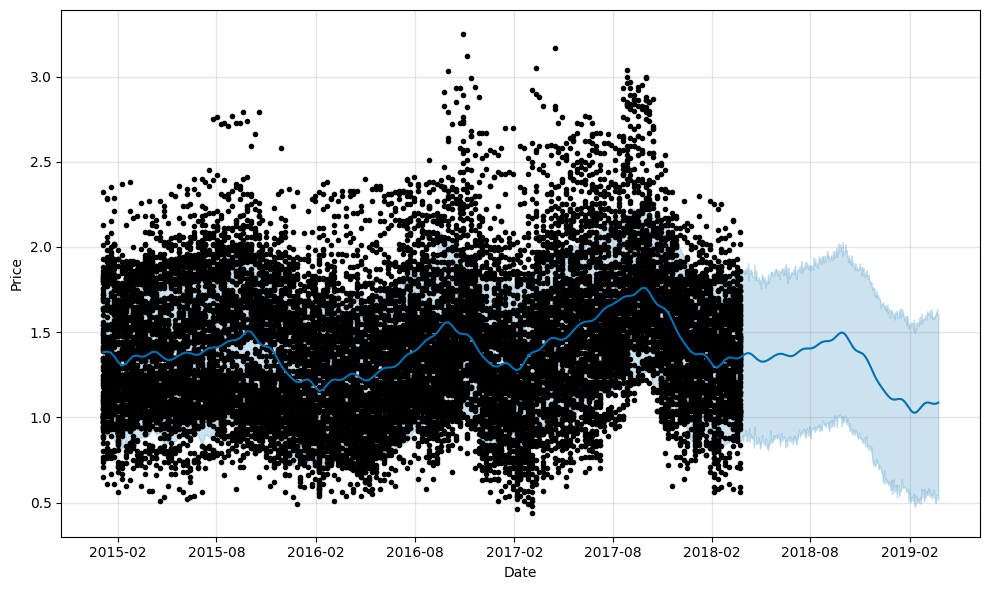

In [14]:
#plotting the predicted trend
figure = m.plot(forcast,xlabel='Date', ylabel='Price')

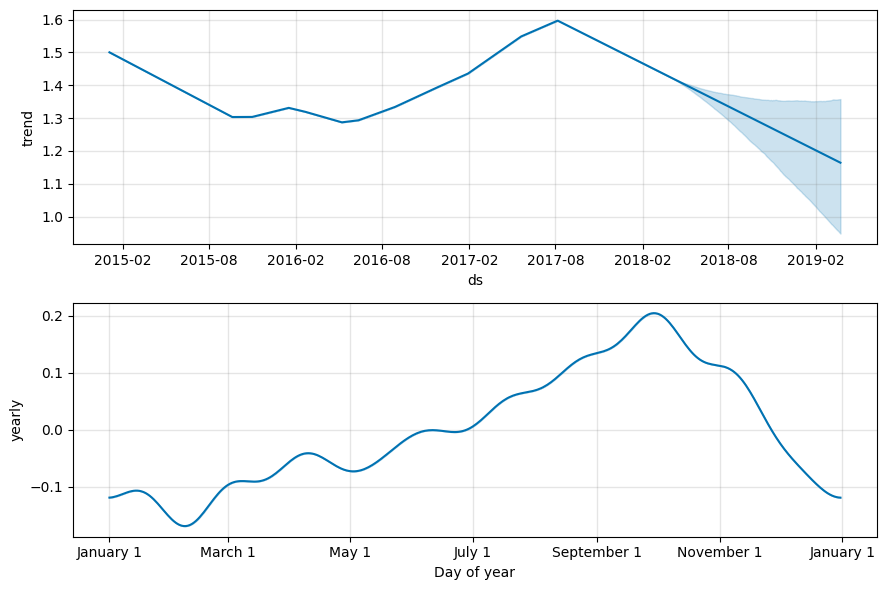

In [15]:
figure = m.plot_components(forcast)

In [21]:
#defining a function to predict price in every region
def region_predict(r):
    df_simple = df[ df.region == r]
    df_simple = df_simple[['Date', 'AveragePrice']]
    df_simple.columns = ['ds', 'y']
    
    m = Prophet()
    m.fit(df_simple)
    df_future = m.make_future_dataframe(periods=365)
    prediction = m.predict(df_future)
    figure = m.plot(prediction, xlabel="Date", ylabel=f'Price({r})',figsize=(8,8))
    

13:54:14 - cmdstanpy - INFO - Chain [1] start processing
13:54:14 - cmdstanpy - INFO - Chain [1] done processing
13:54:14 - cmdstanpy - INFO - Chain [1] start processing
13:54:14 - cmdstanpy - INFO - Chain [1] done processing
13:54:14 - cmdstanpy - INFO - Chain [1] start processing
13:54:15 - cmdstanpy - INFO - Chain [1] done processing
13:54:15 - cmdstanpy - INFO - Chain [1] start processing
13:54:15 - cmdstanpy - INFO - Chain [1] done processing
13:54:15 - cmdstanpy - INFO - Chain [1] start processing
13:54:16 - cmdstanpy - INFO - Chain [1] done processing
13:54:16 - cmdstanpy - INFO - Chain [1] start processing
13:54:16 - cmdstanpy - INFO - Chain [1] done processing
13:54:16 - cmdstanpy - INFO - Chain [1] start processing
13:54:16 - cmdstanpy - INFO - Chain [1] done processing
13:54:17 - cmdstanpy - INFO - Chain [1] start processing
13:54:17 - cmdstanpy - INFO - Chain [1] done processing
13:54:17 - cmdstanpy - INFO - Chain [1] start processing
13:54:17 - cmdstanpy - INFO - Chain [1]

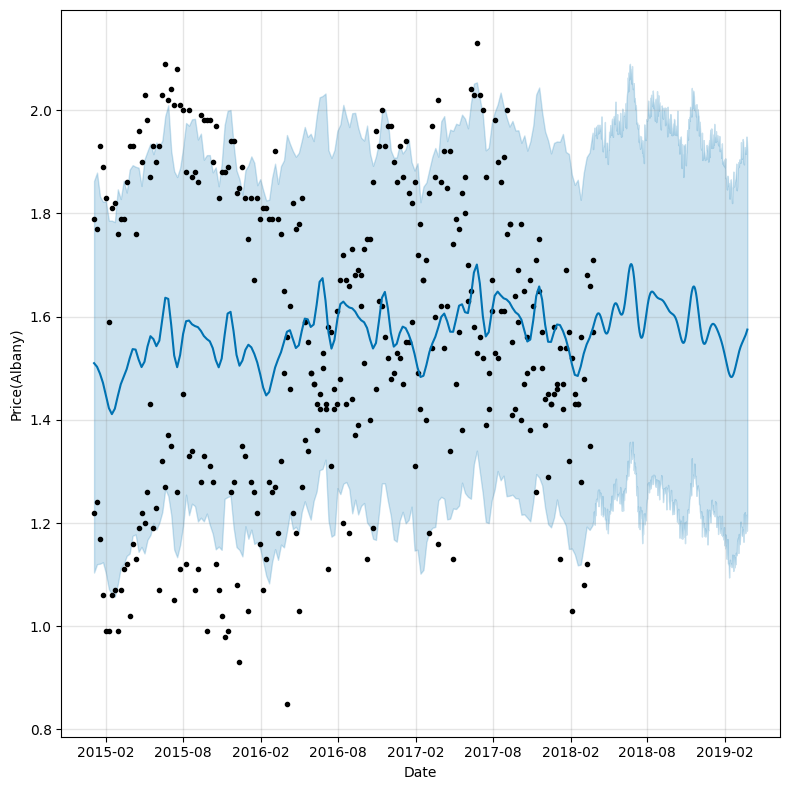

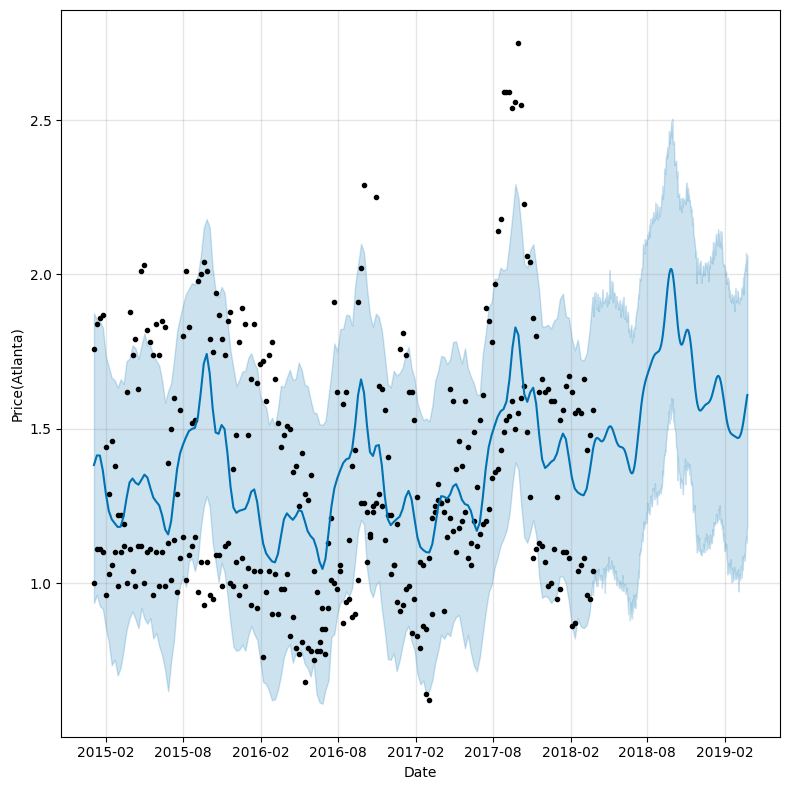

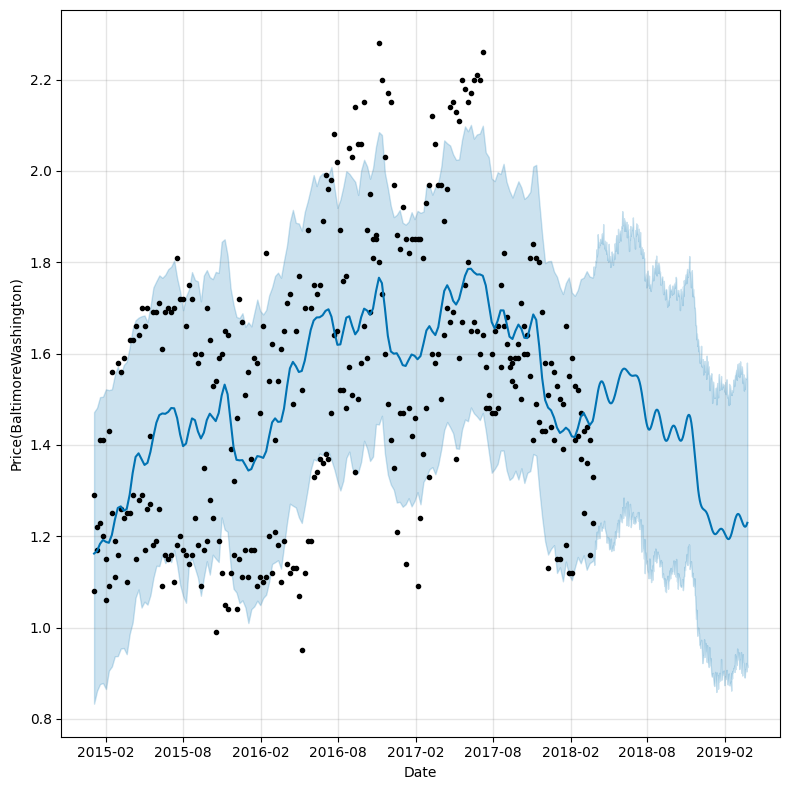

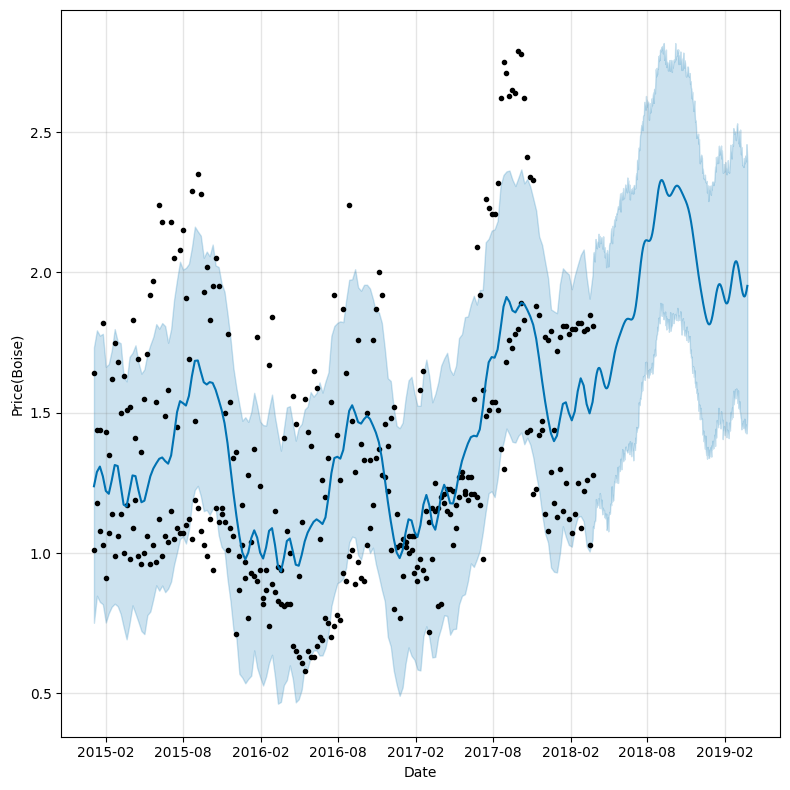

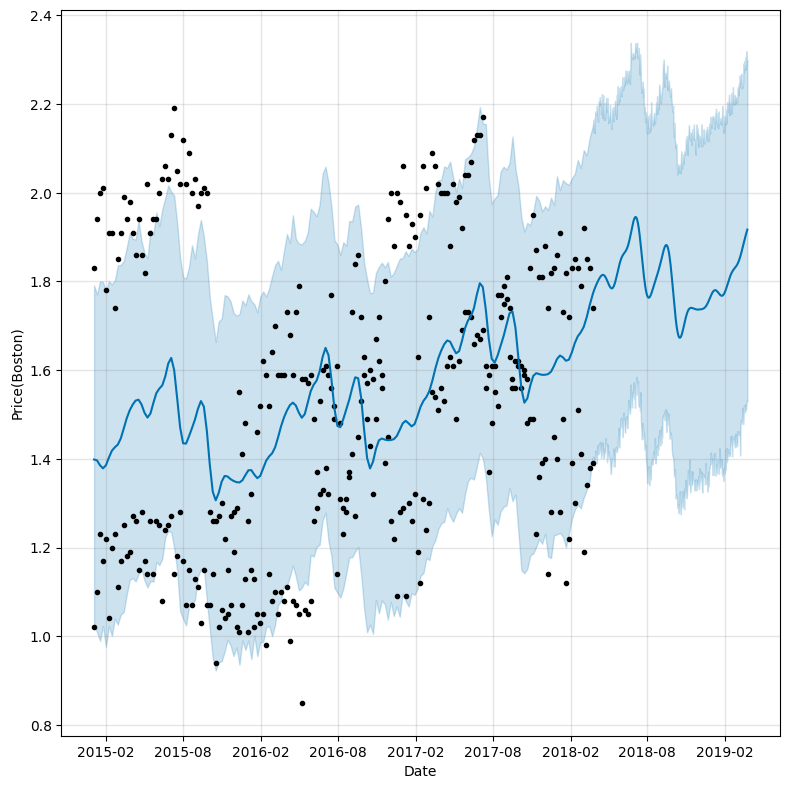

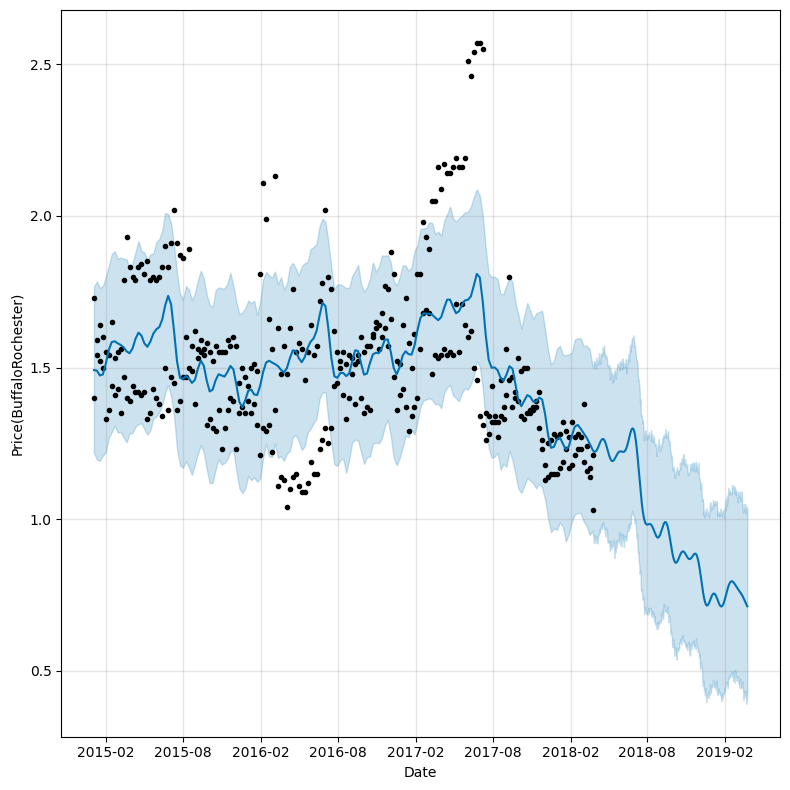

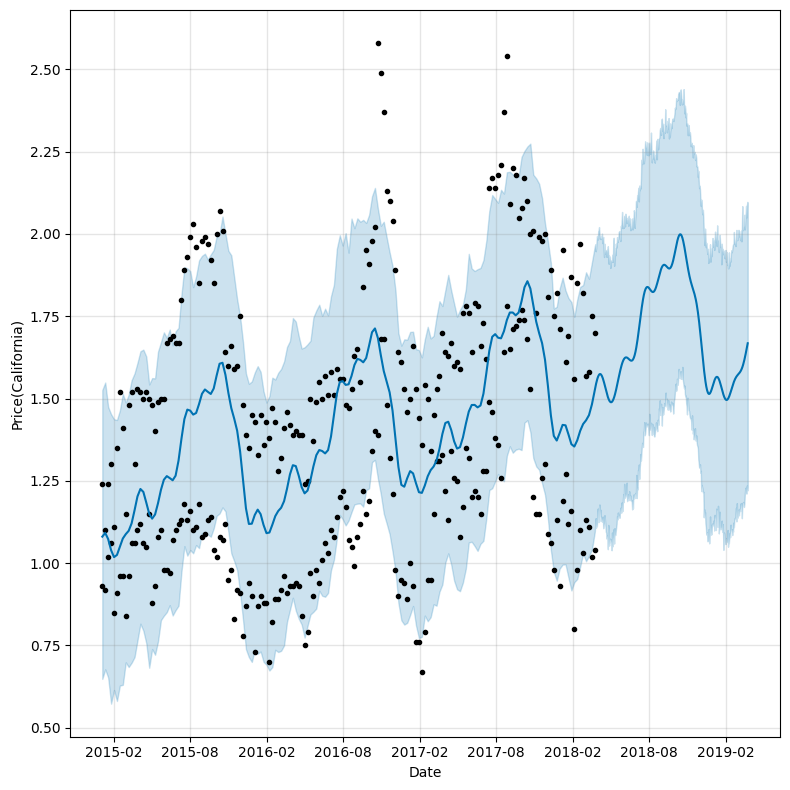

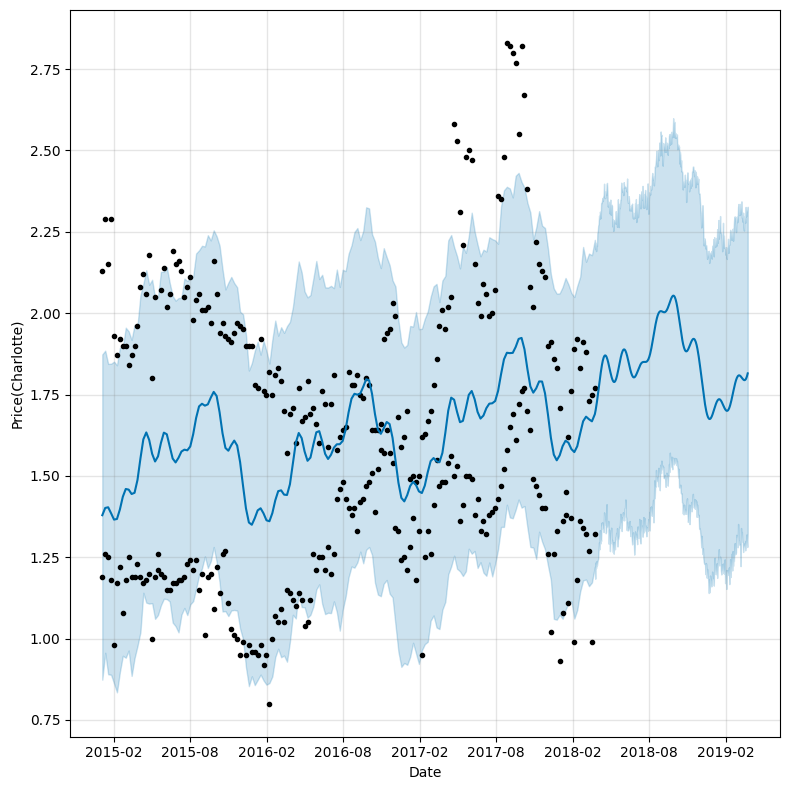

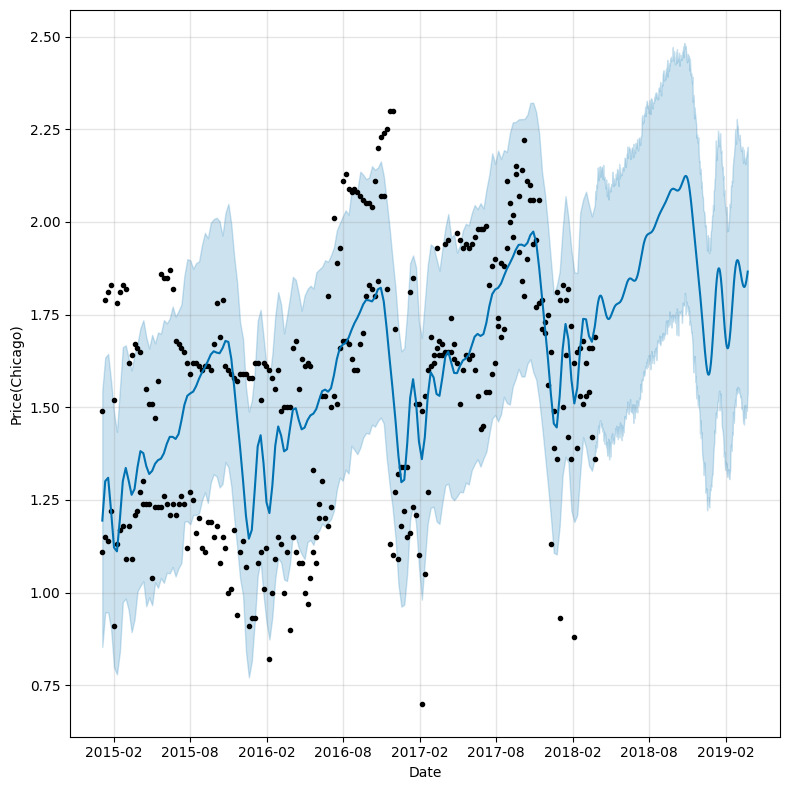

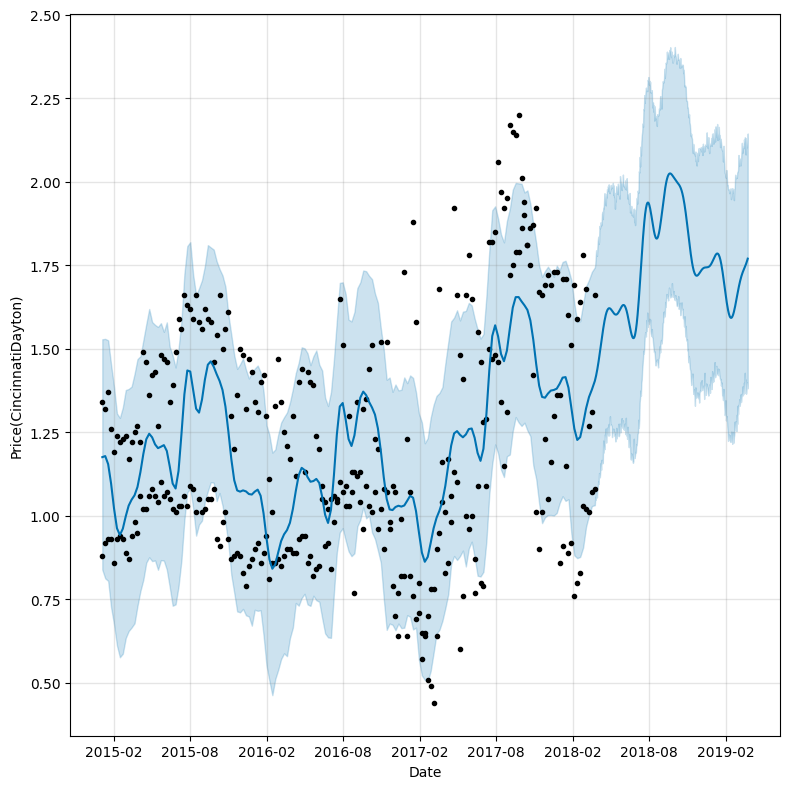

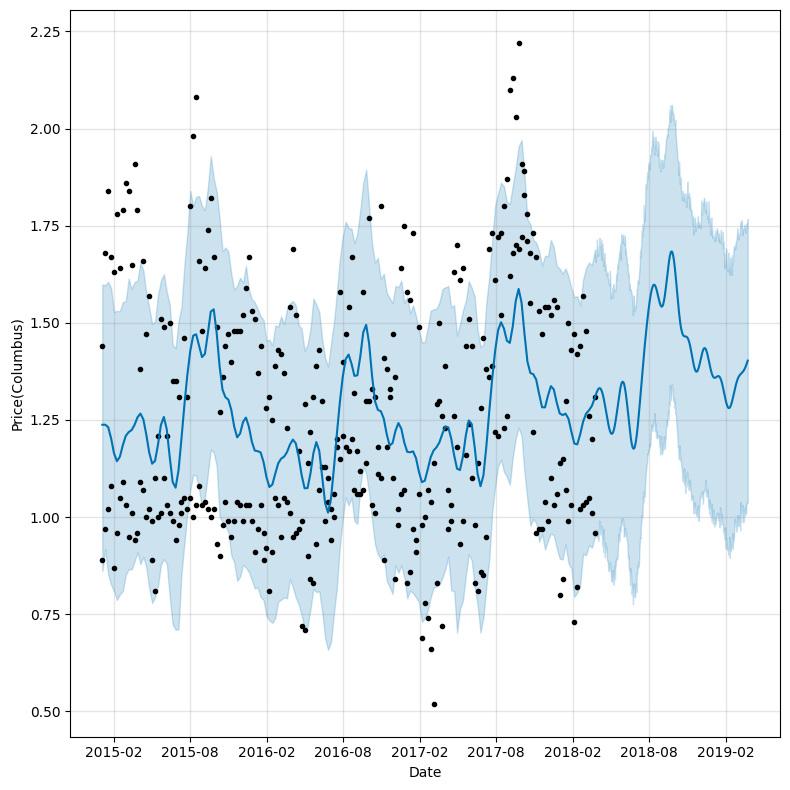

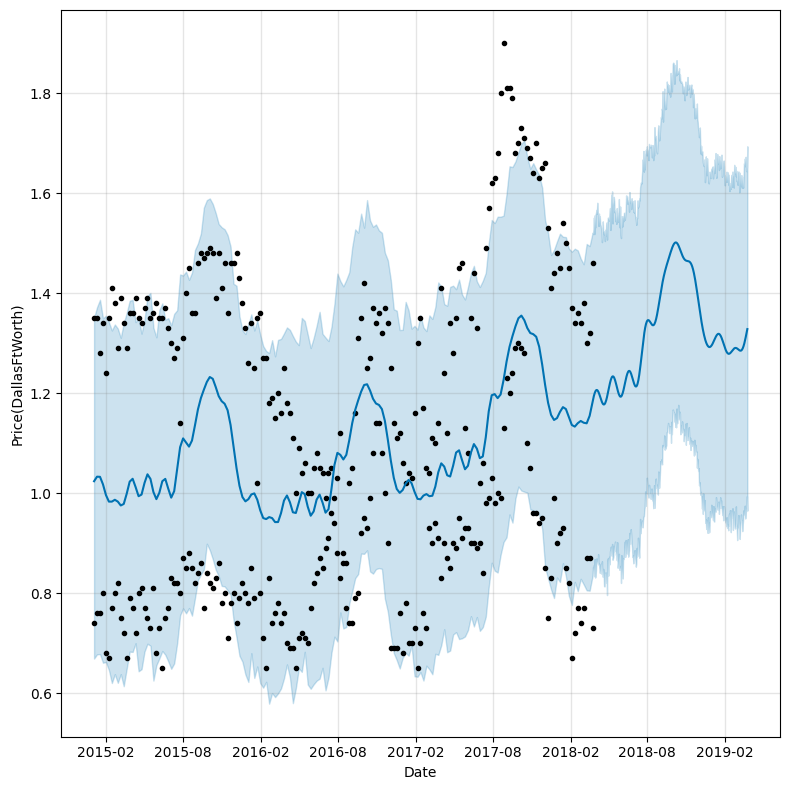

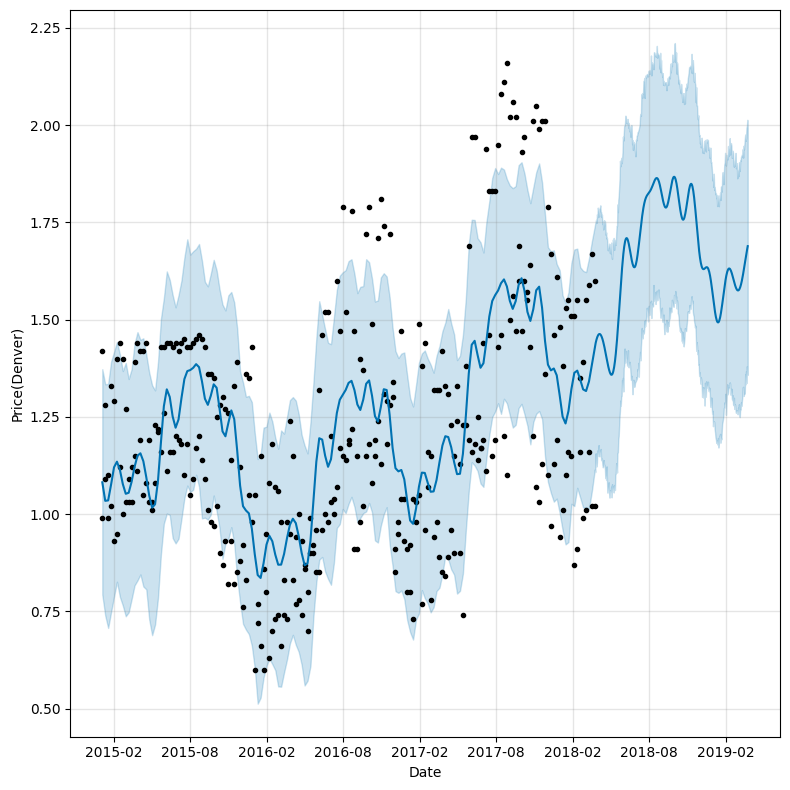

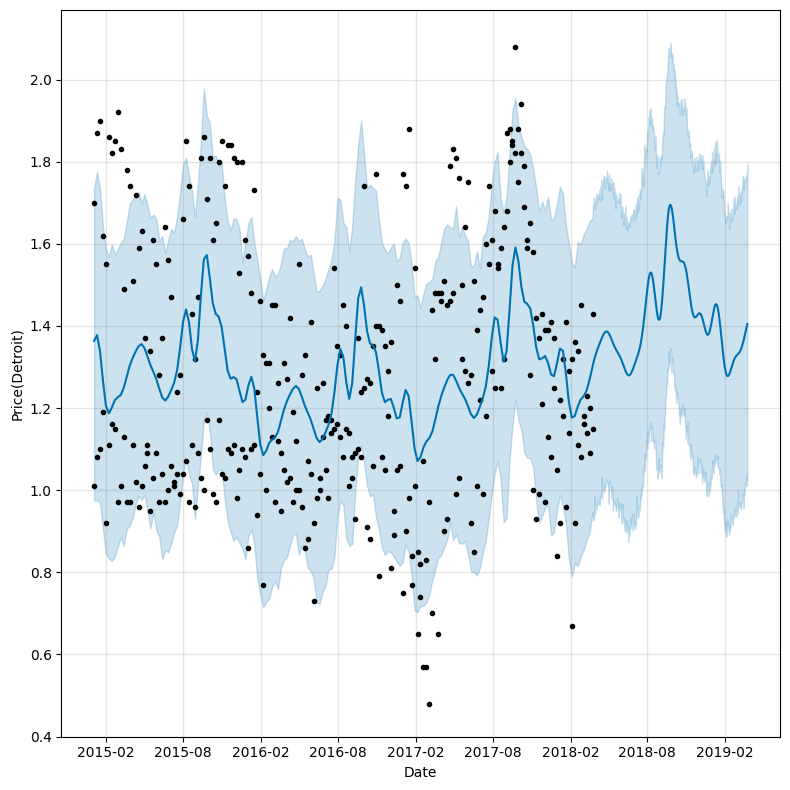

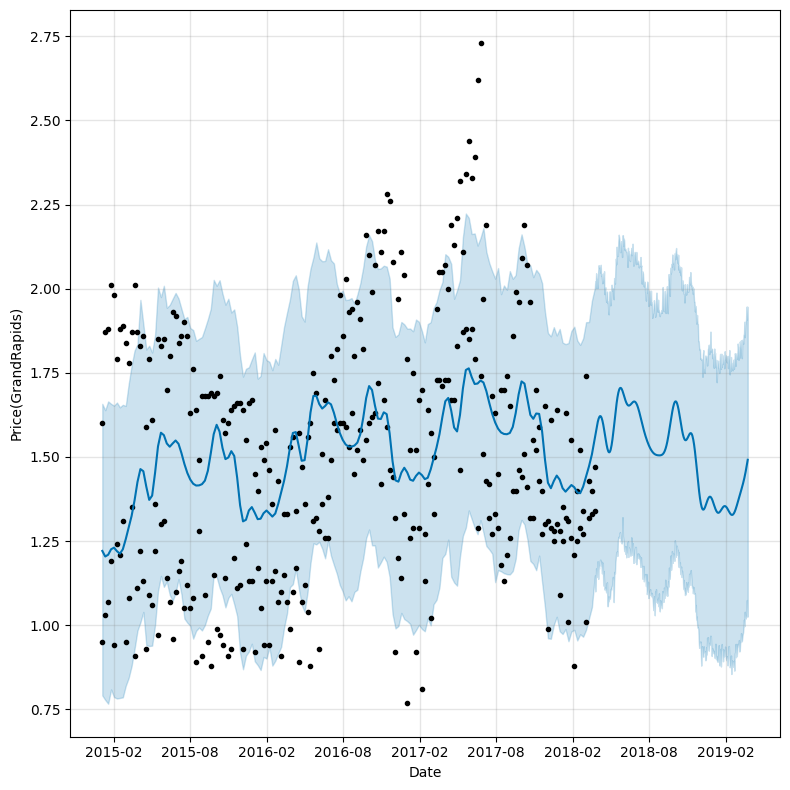

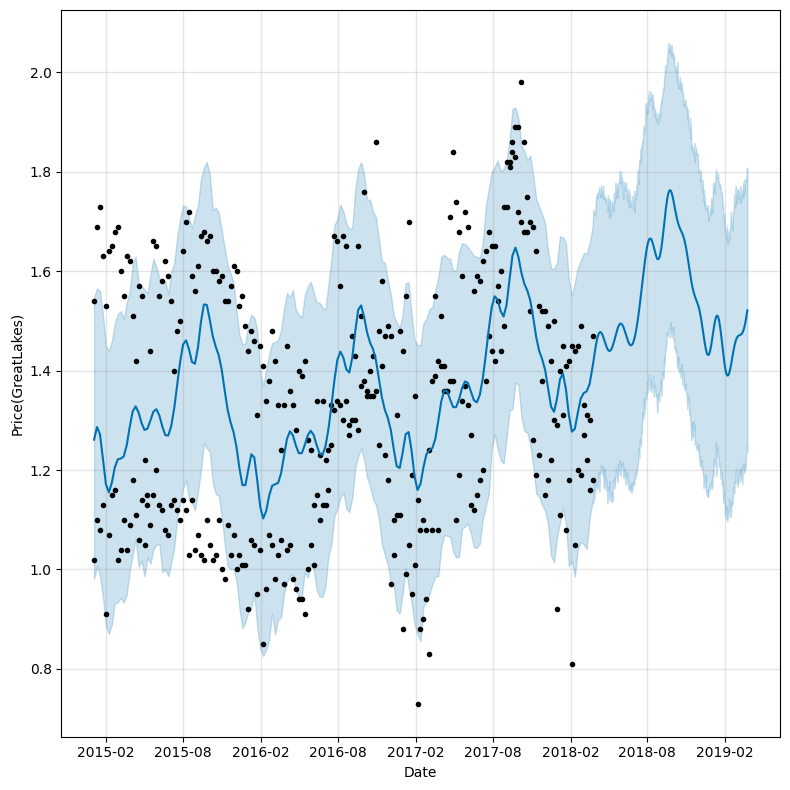

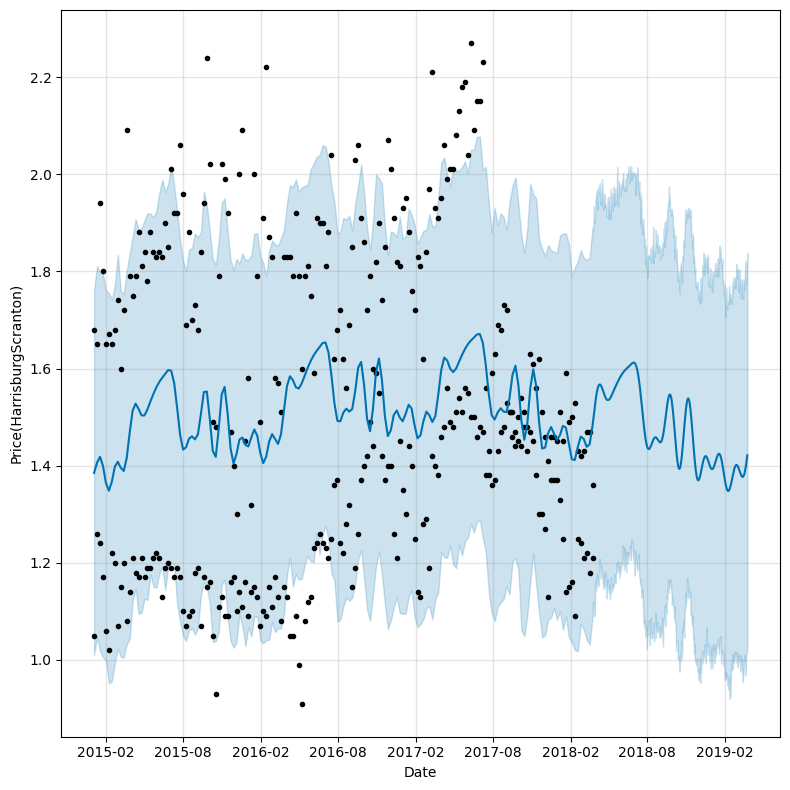

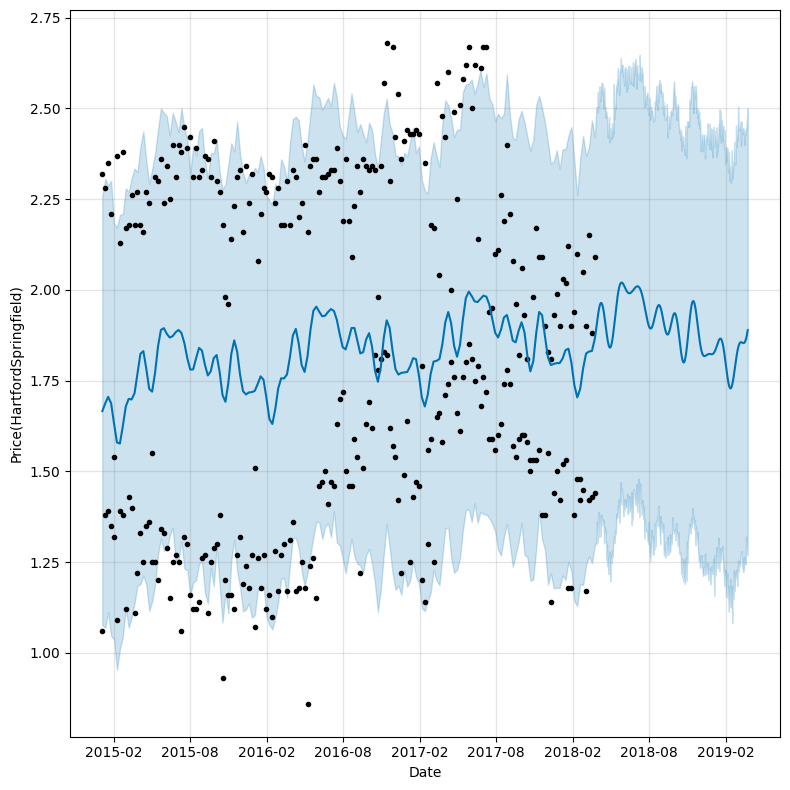

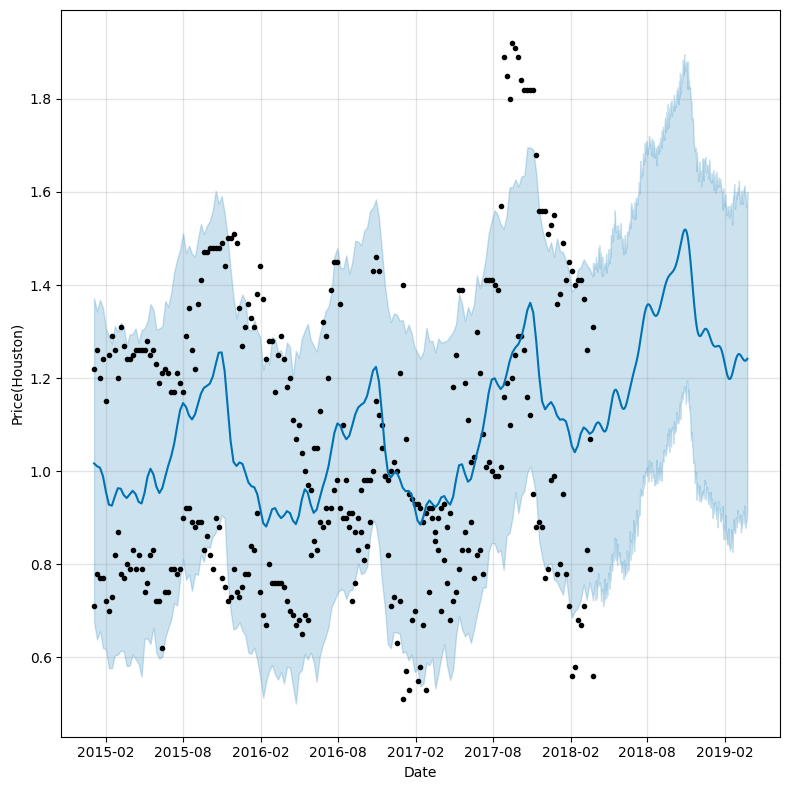

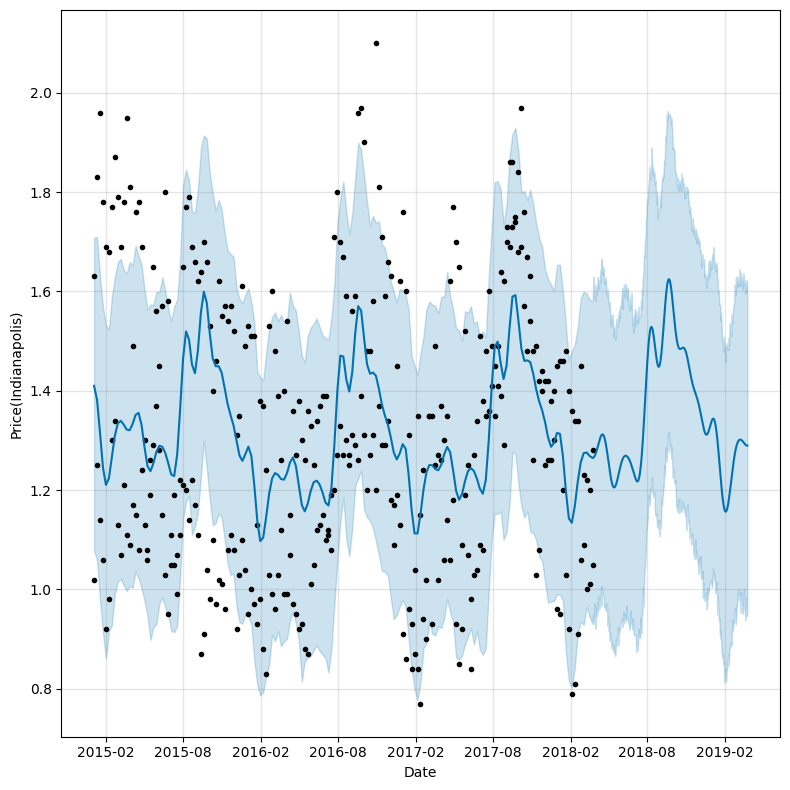

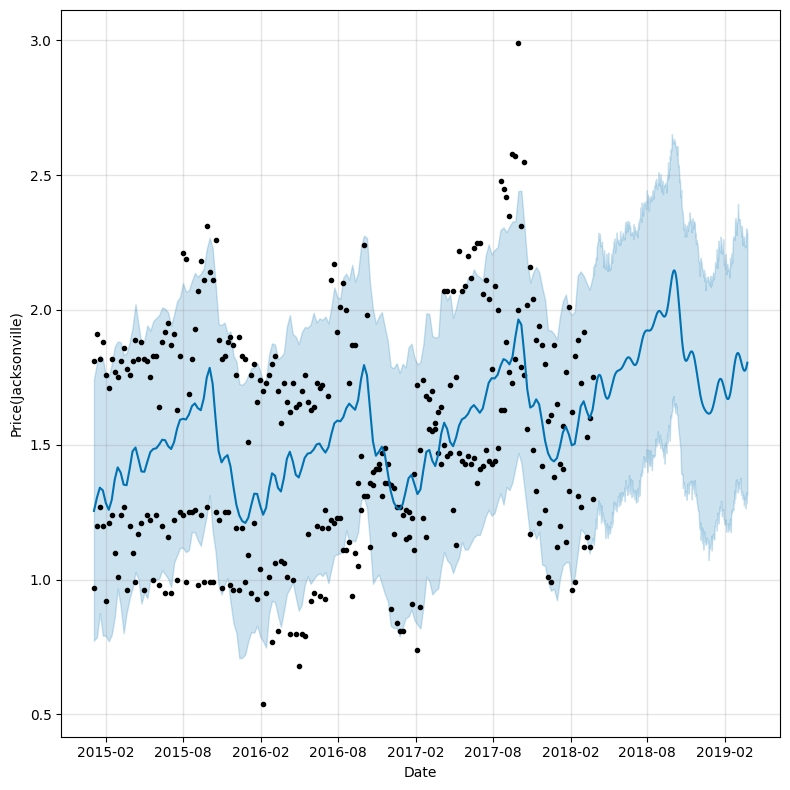

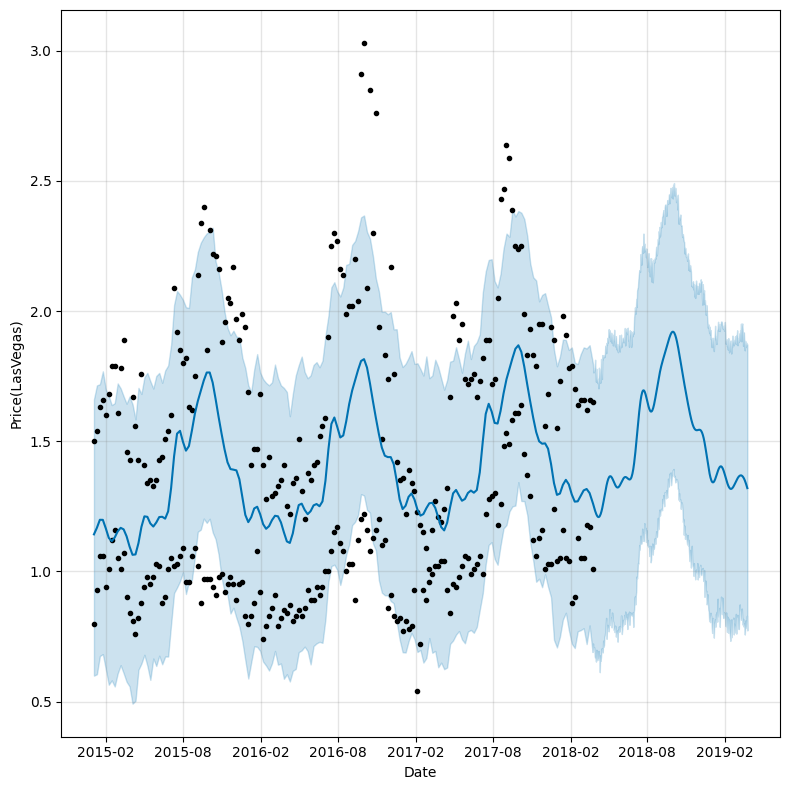

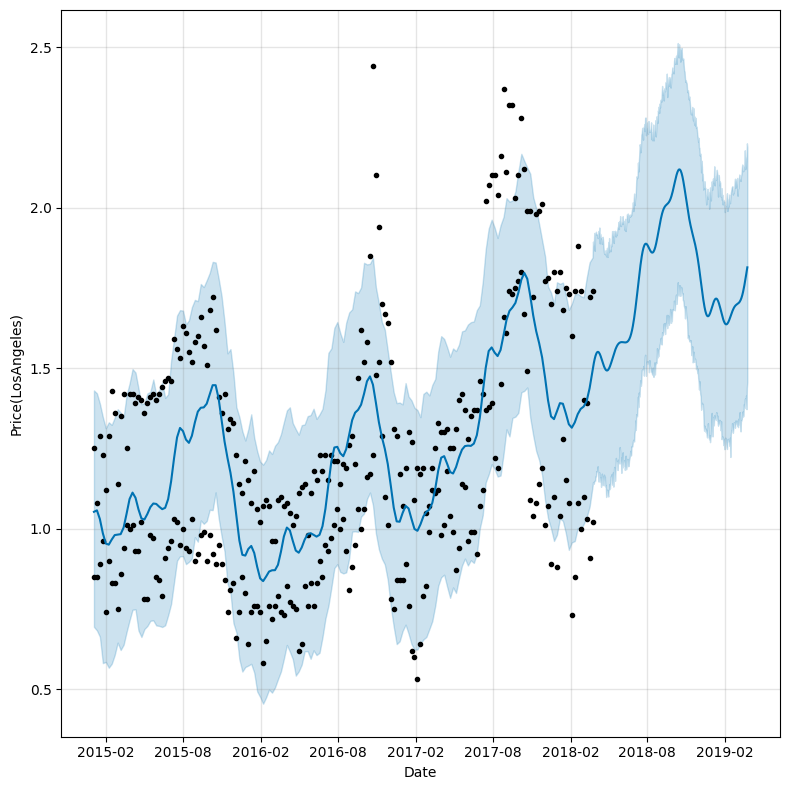

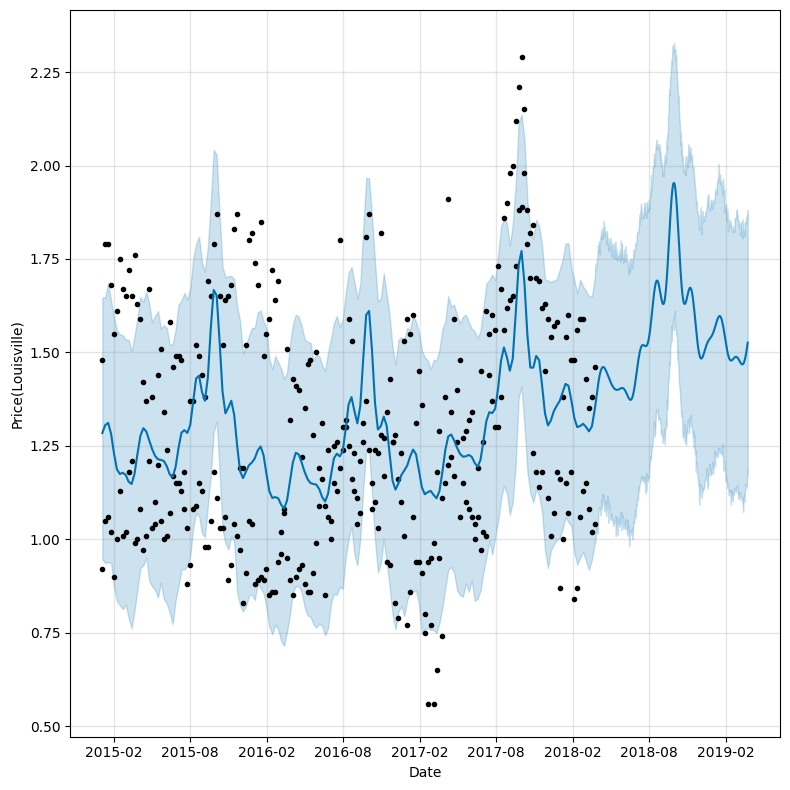

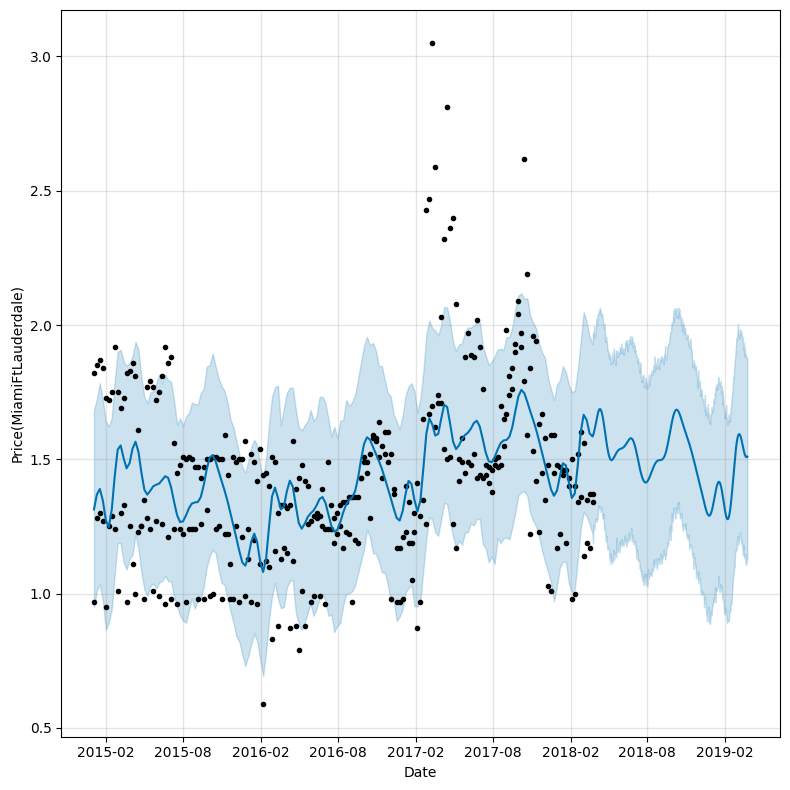

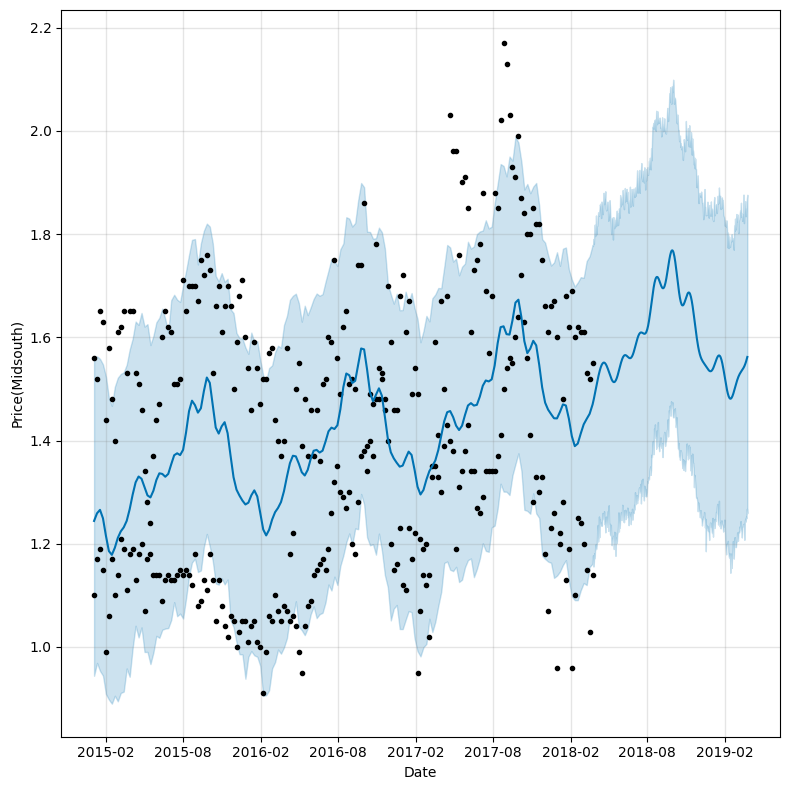

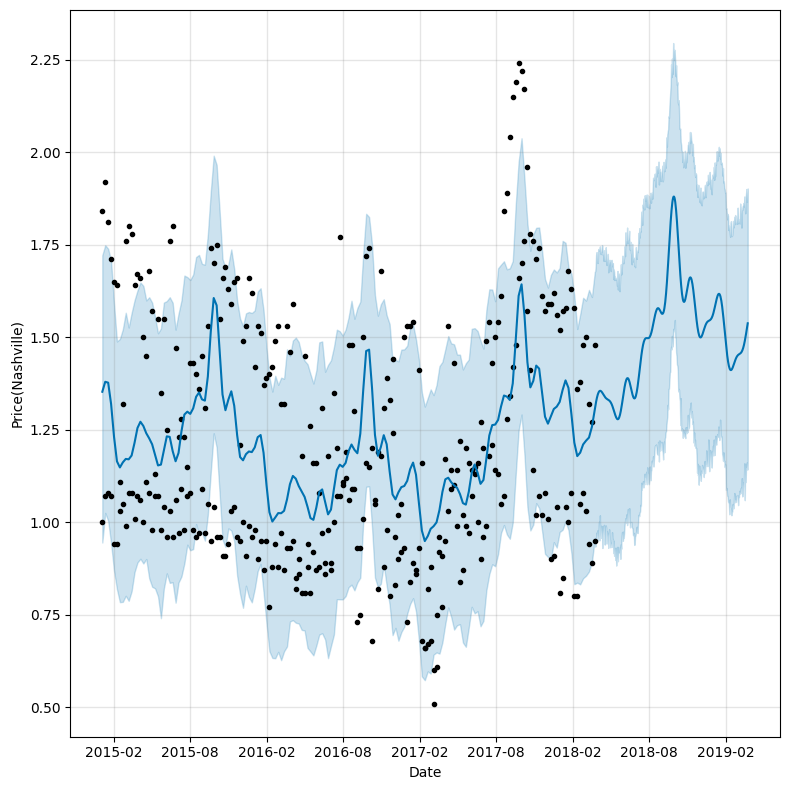

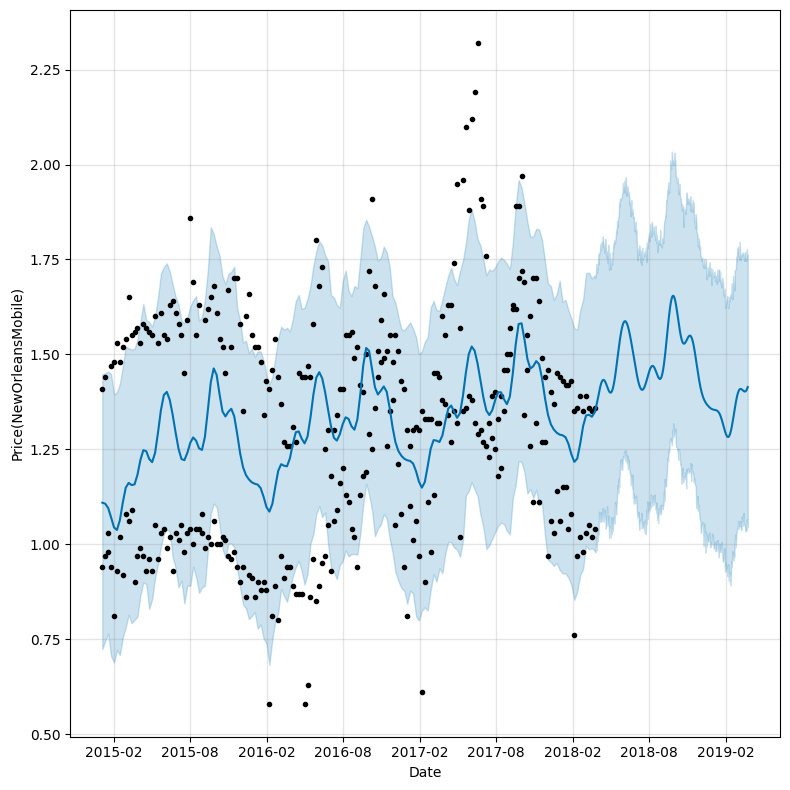

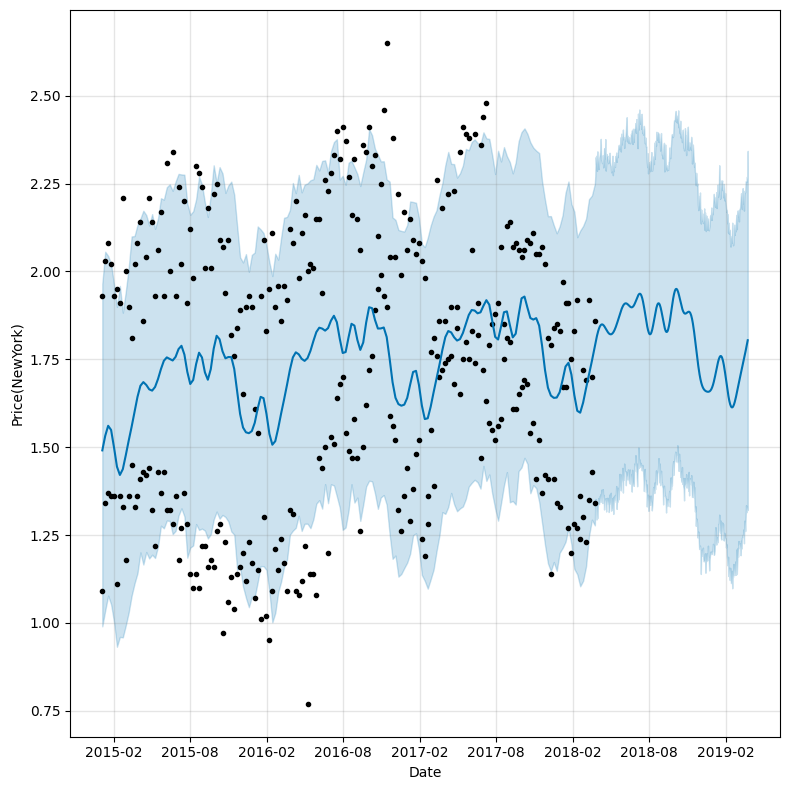

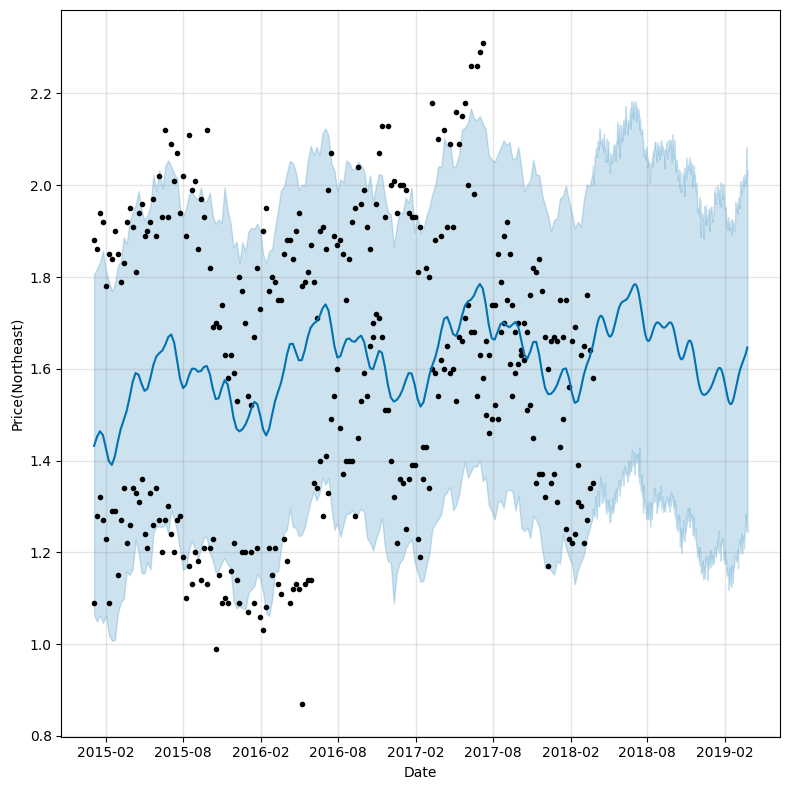

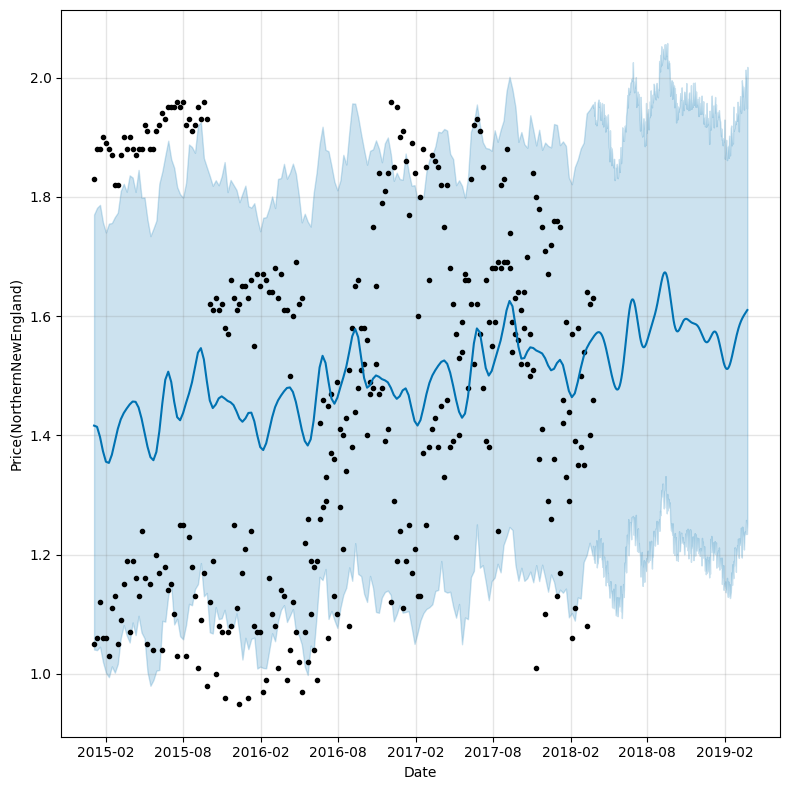

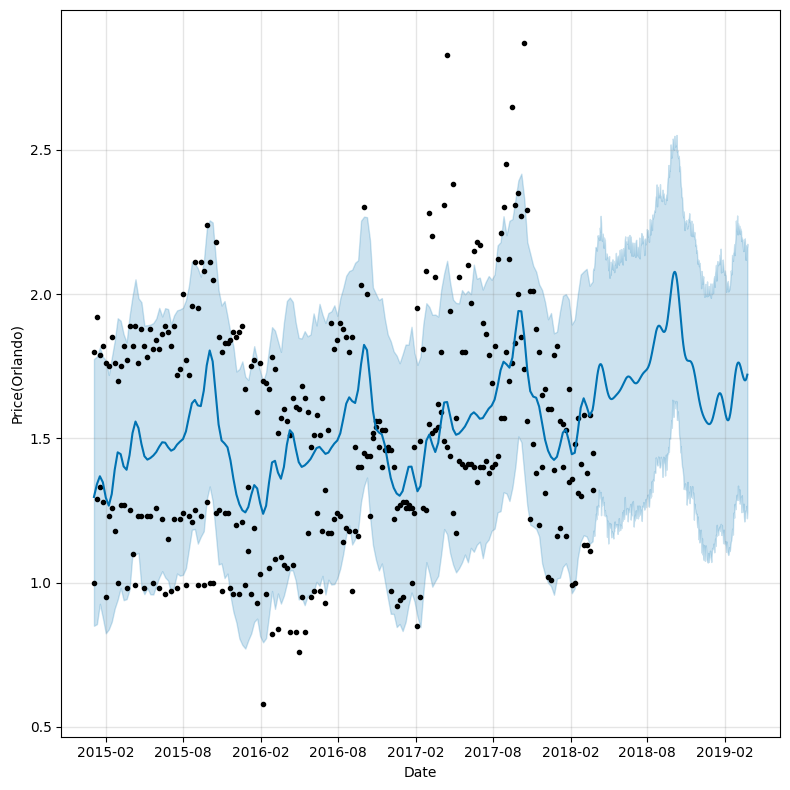

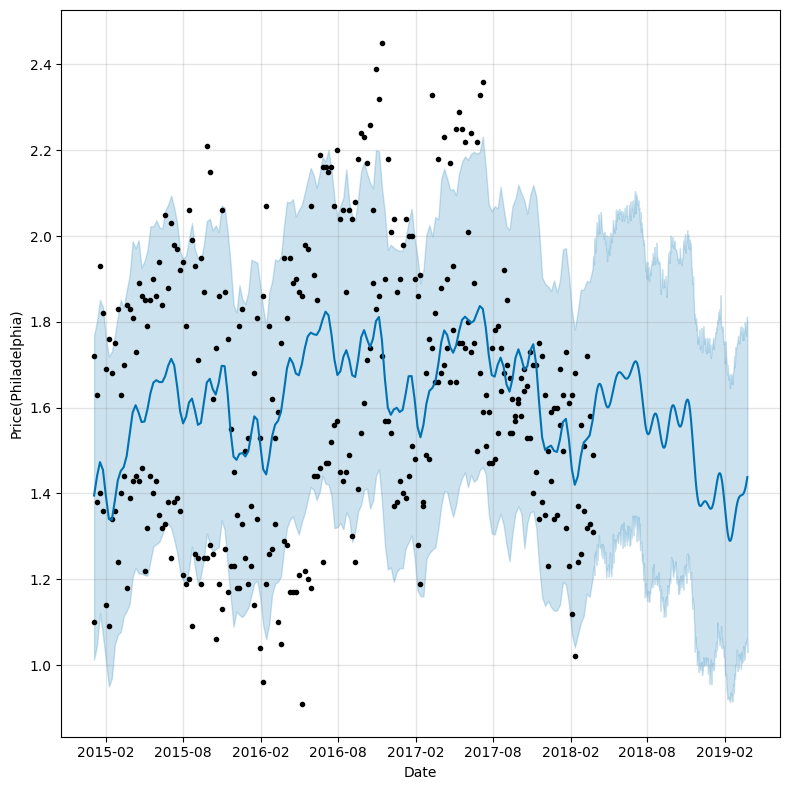

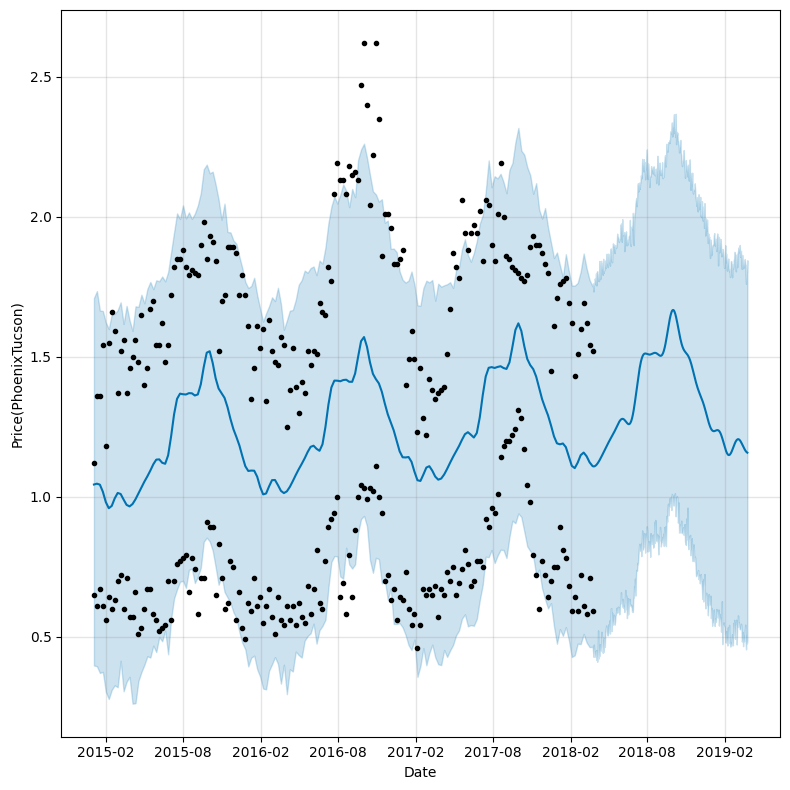

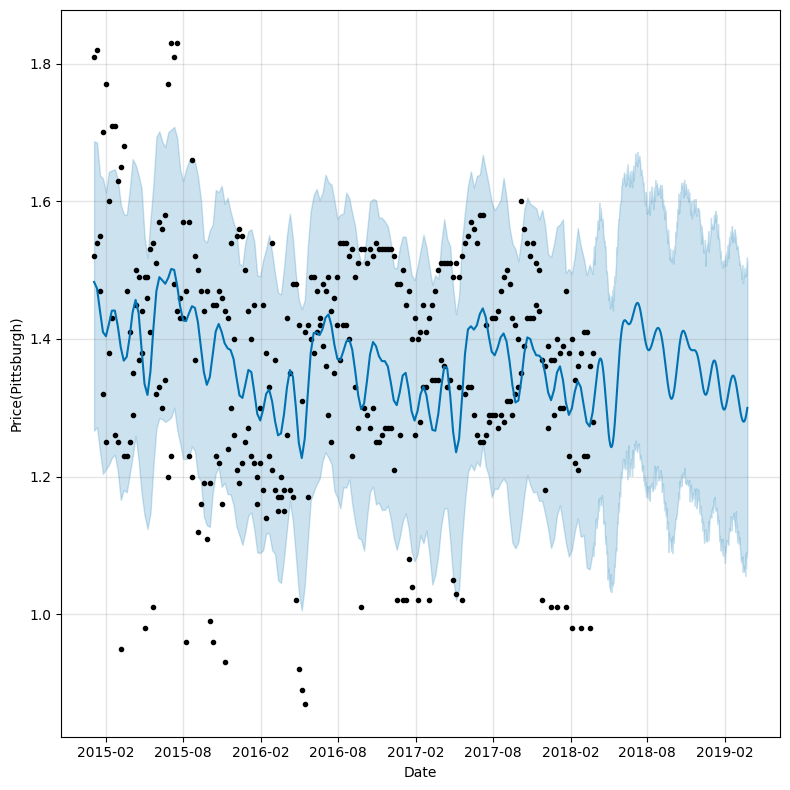

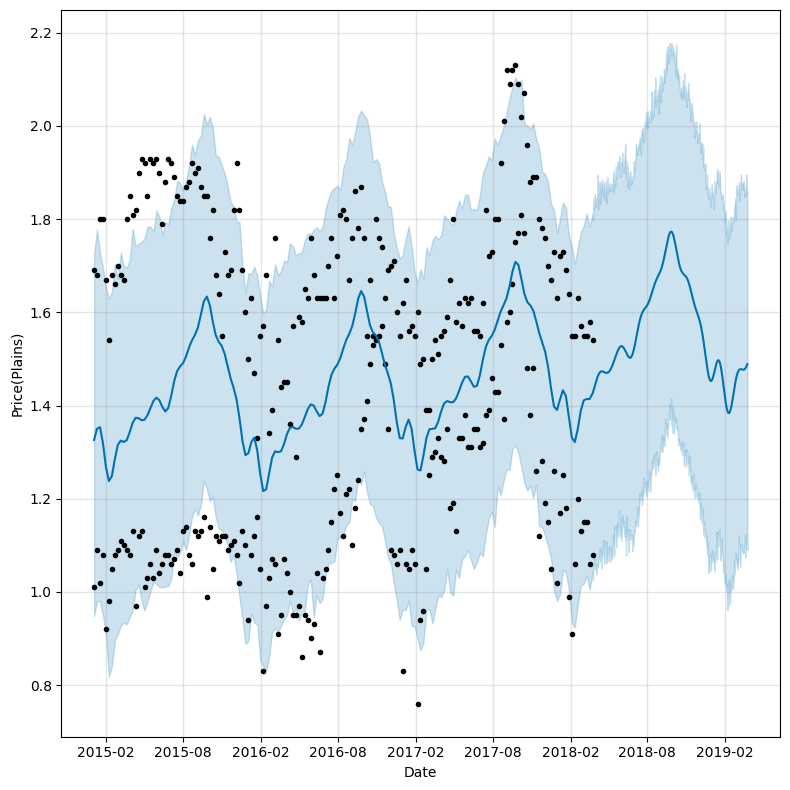

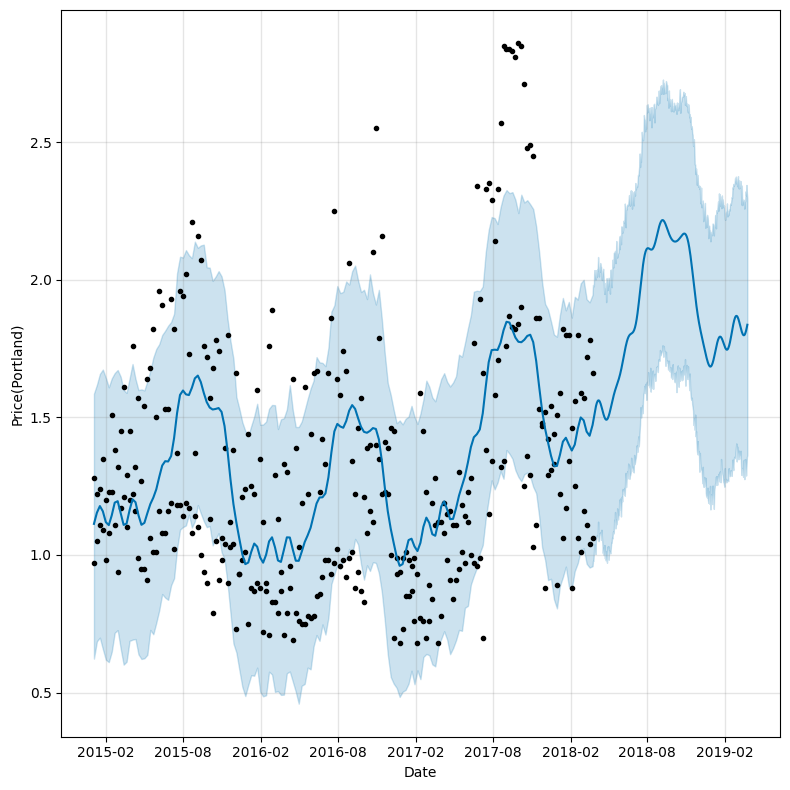

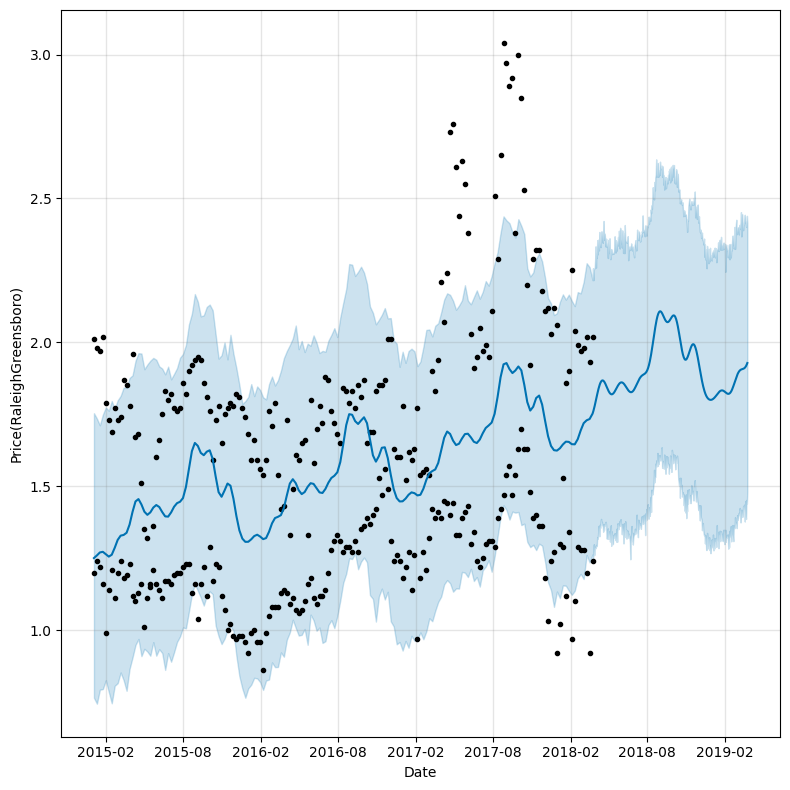

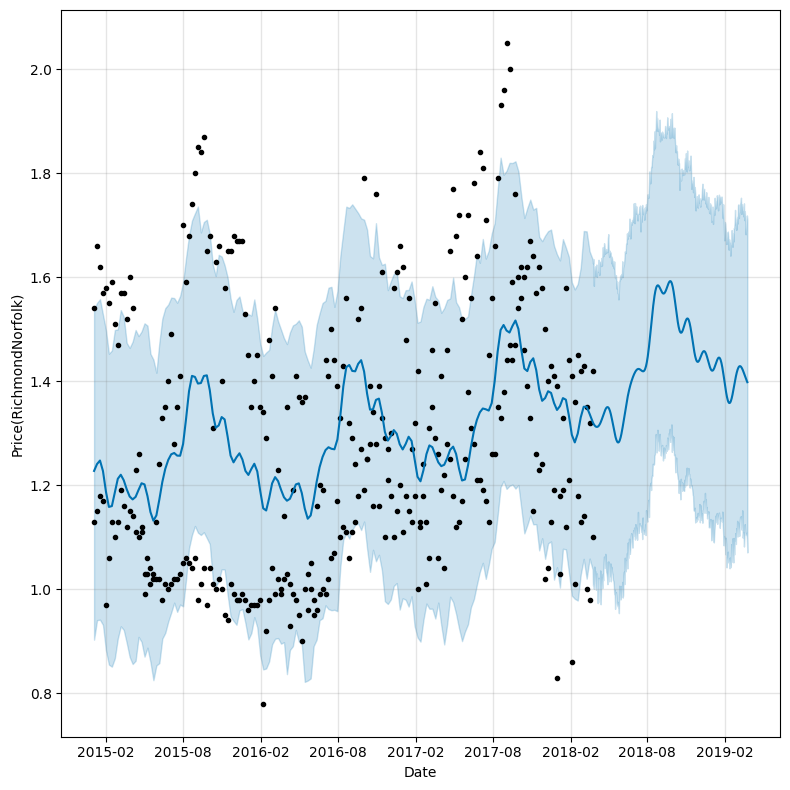

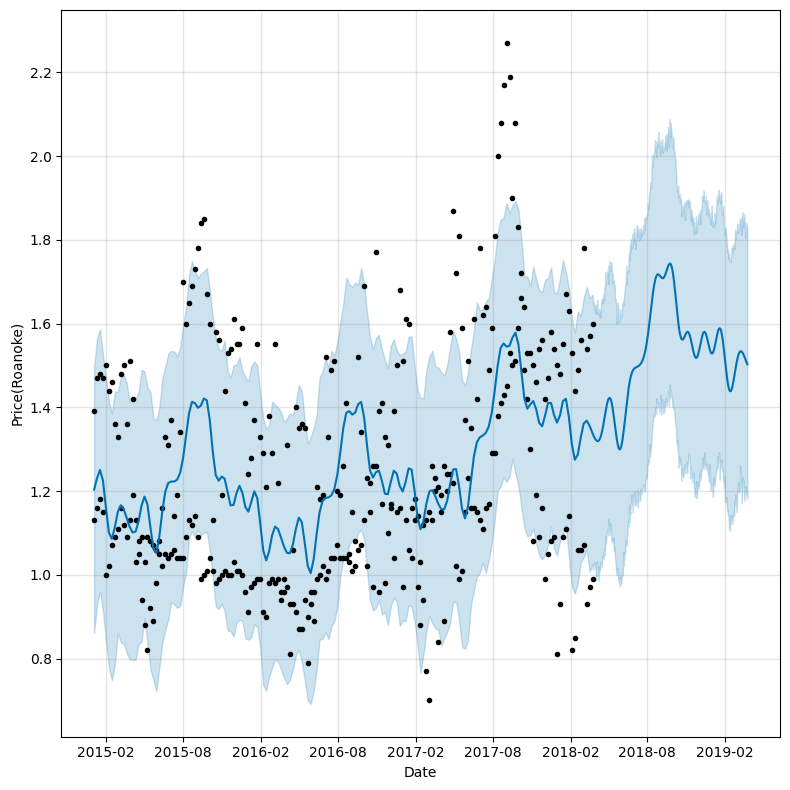

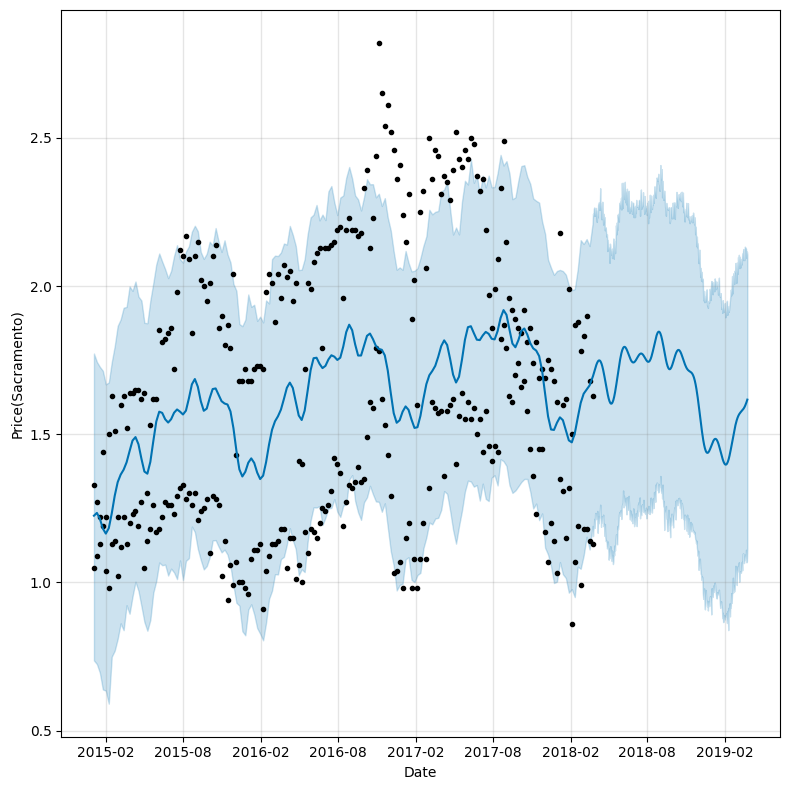

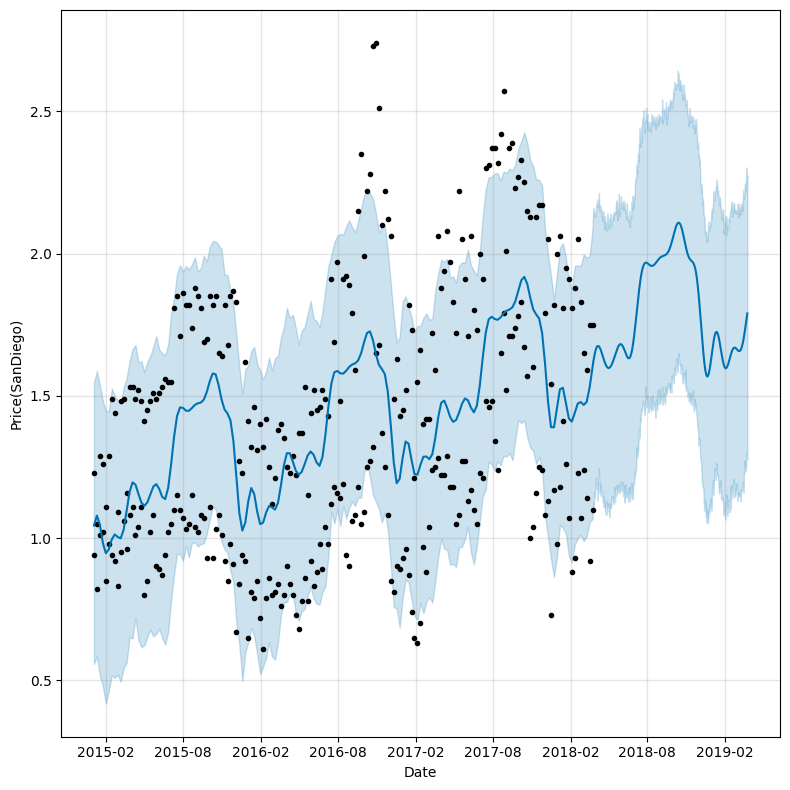

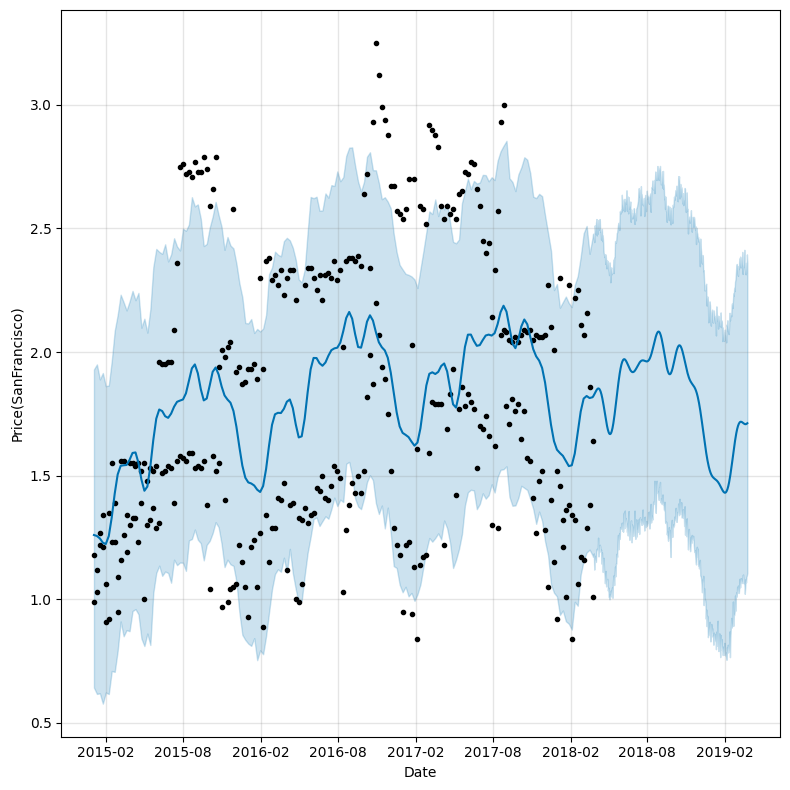

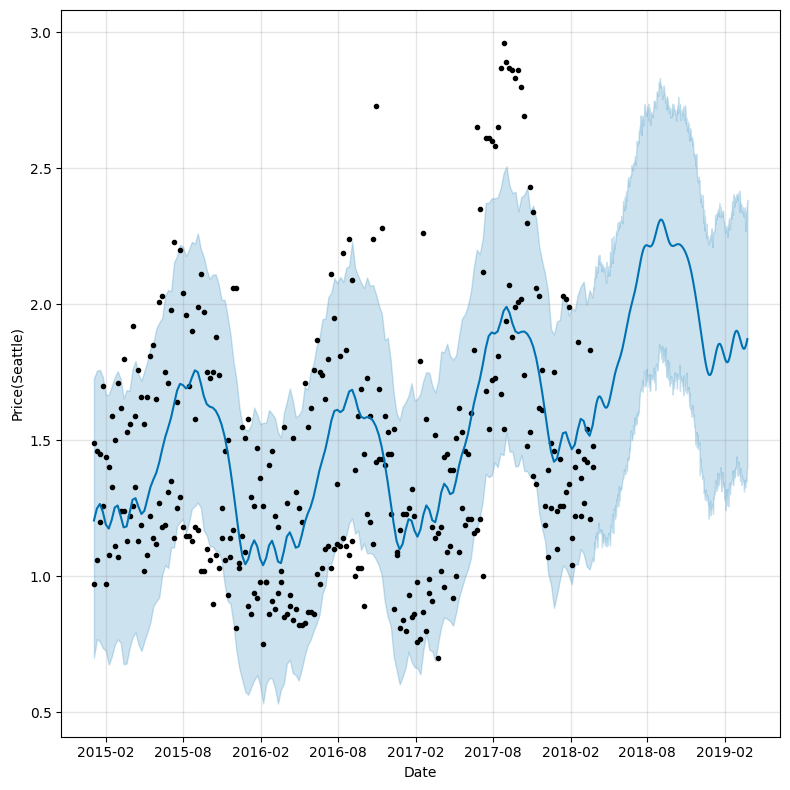

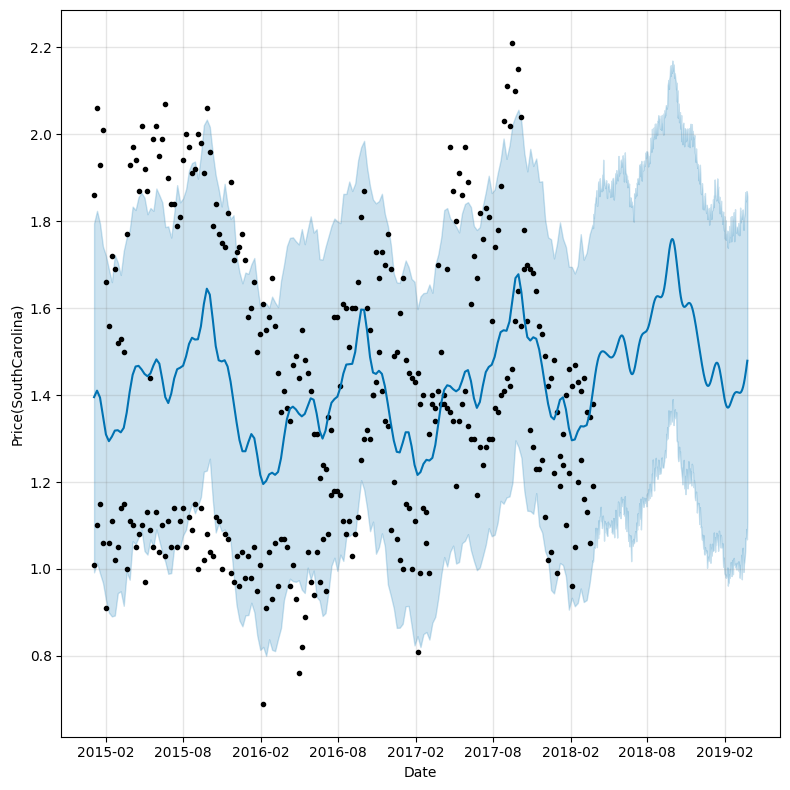

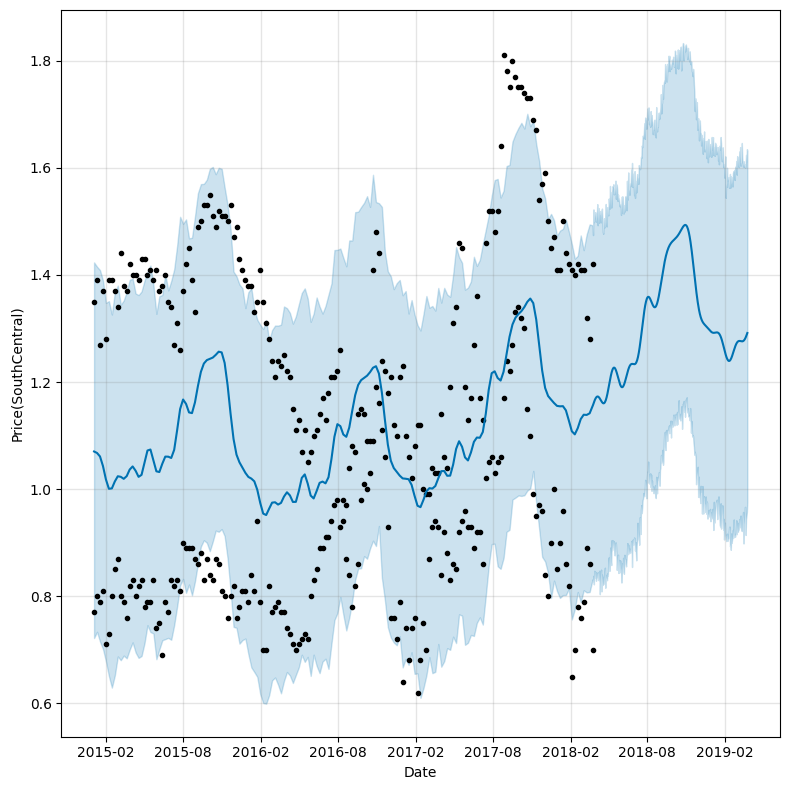

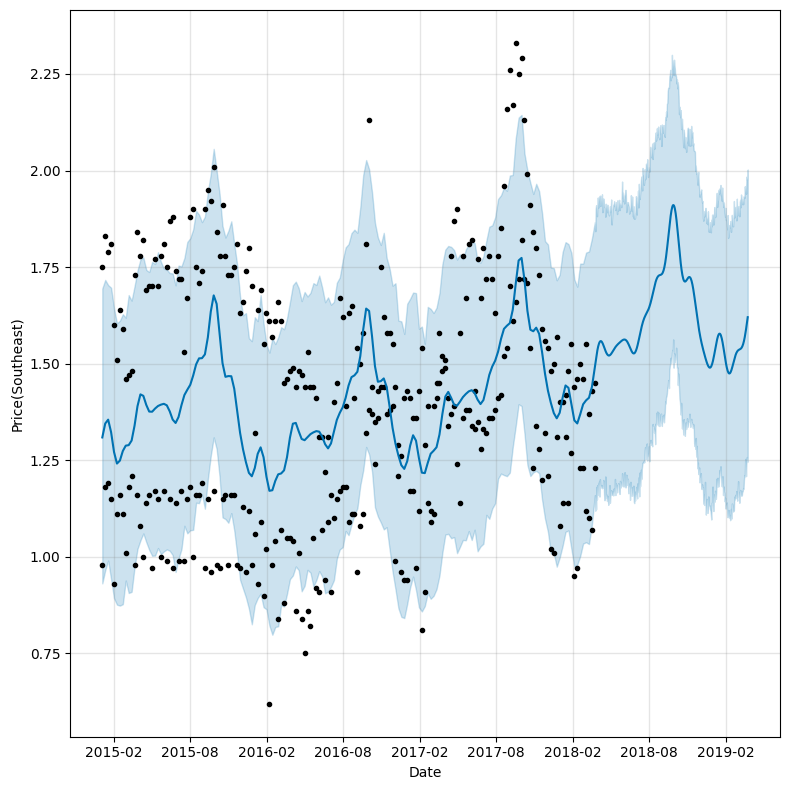

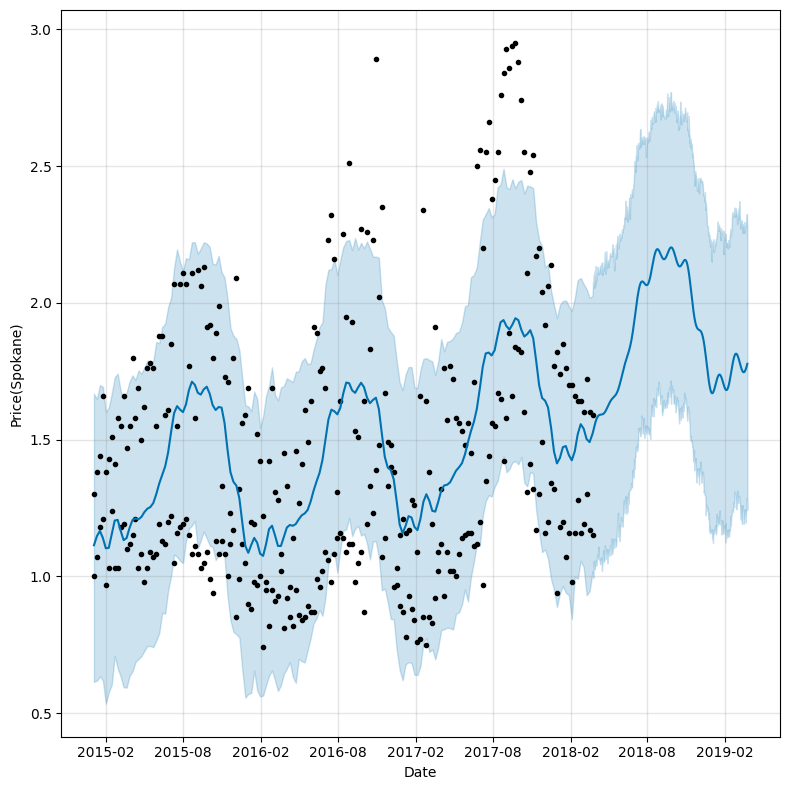

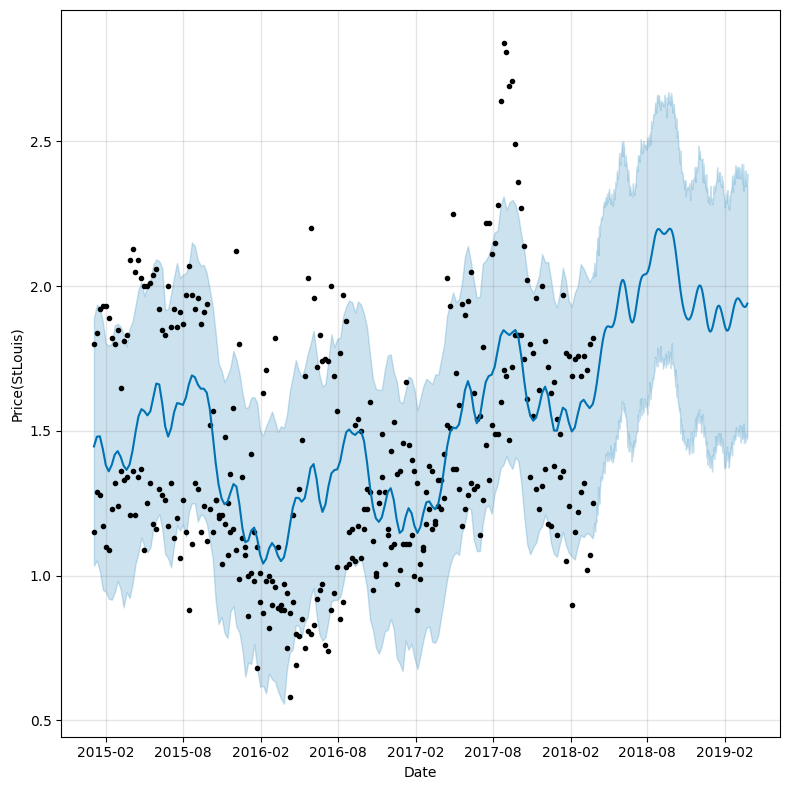

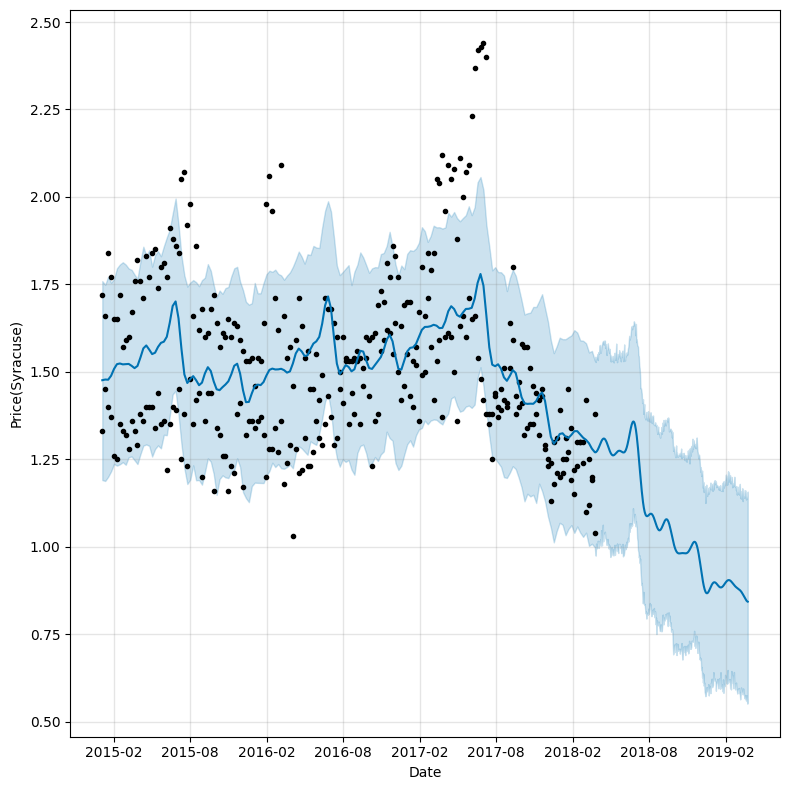

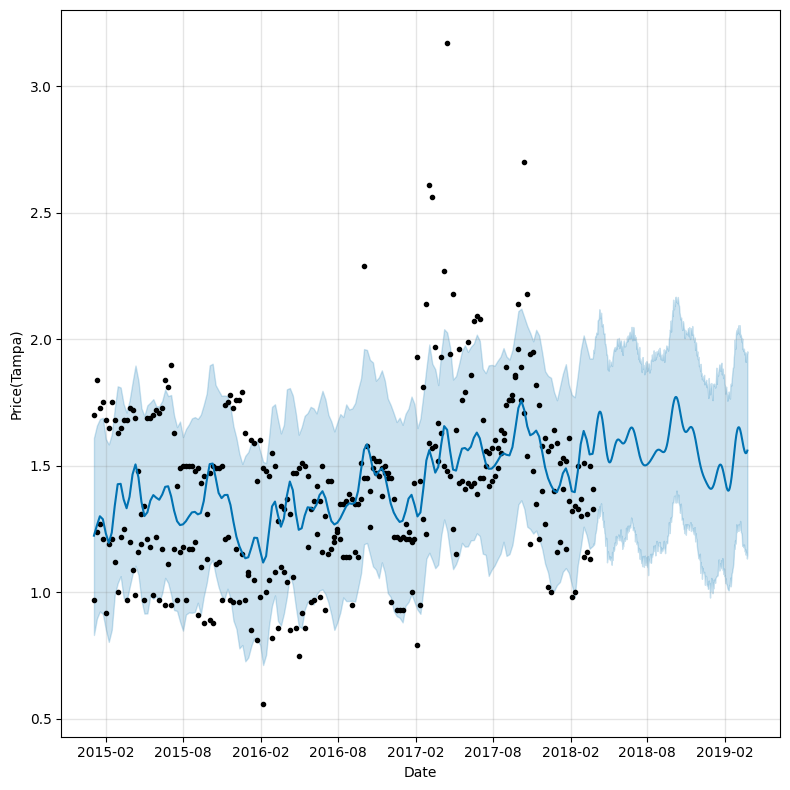

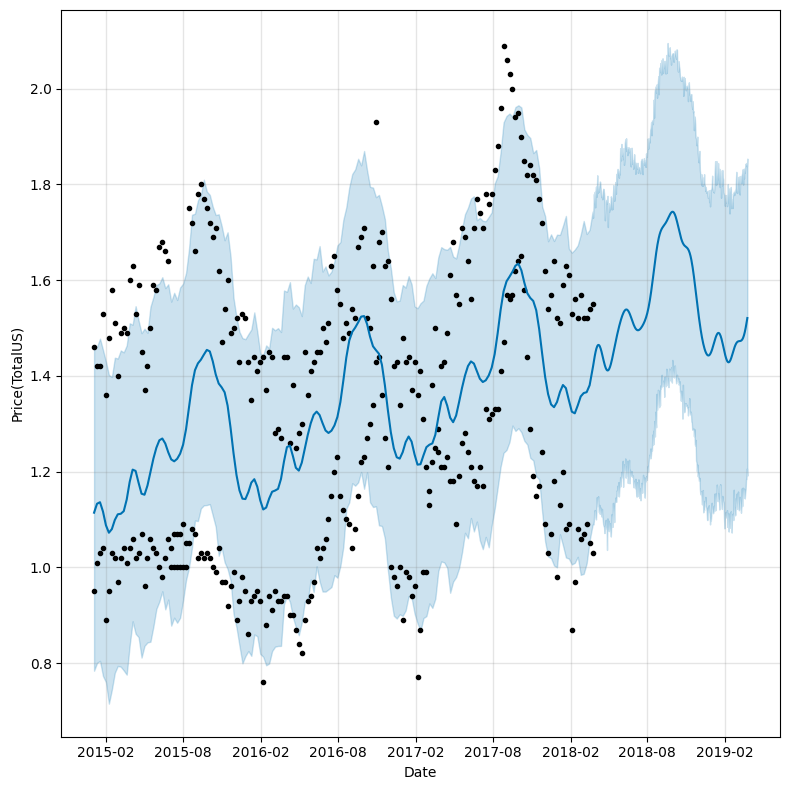

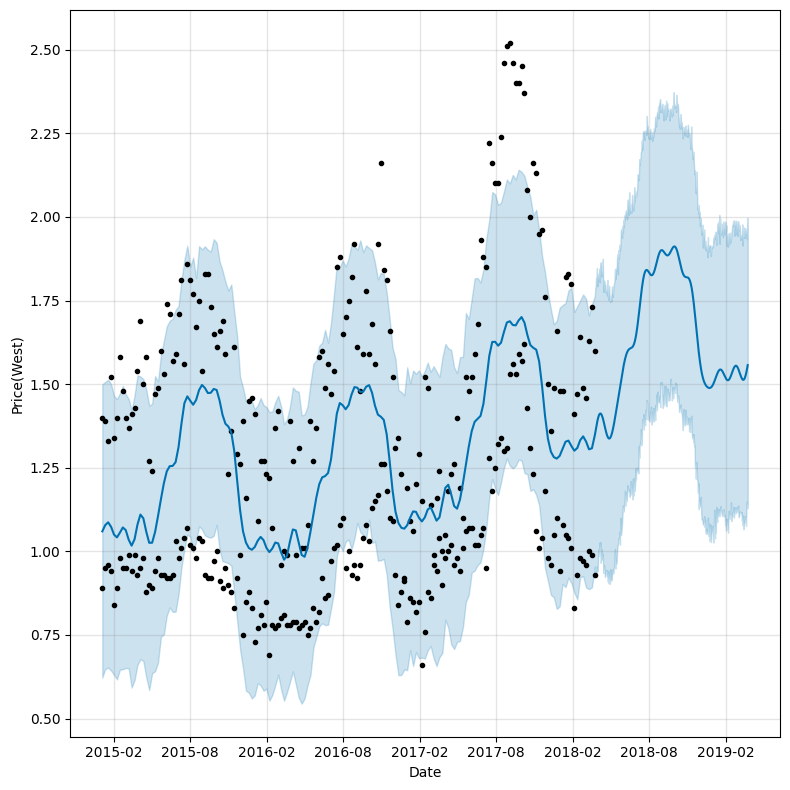

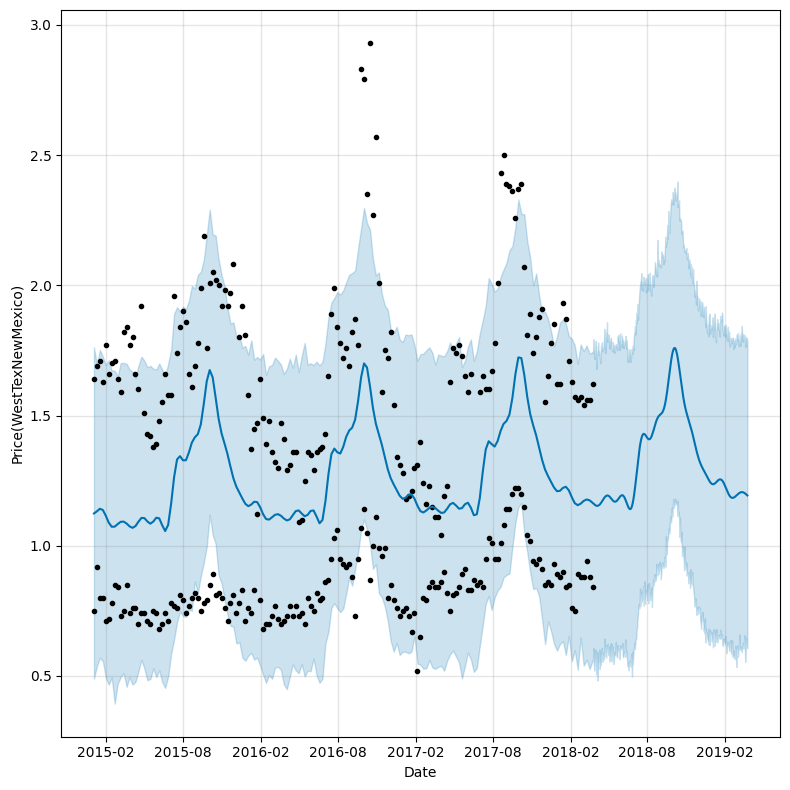

In [22]:
for i in list(df.region.unique()):
    region_predict(i)